GANs are widely used for synthesizing new data, especially images. However, one drawback of normal GANs is that we have no control over the images GANs produce. For instance, a GAN that is trained to produce fake hand-written digit images may be able to generate very real hand-written digit images, but we have no control over which number it generates. **InfoGAN solved this problem: the network can learn to produce images with specific categorical features (such as digits 0 to 9) and continuous features (such as the rotational angle of the digits), in an unsupervised manner. In addition, because the learning is unsupervised, it is able to find the patterns hidden among the images, and generate images that follow these hidden patterns.** Sometimes the model can learn very interesting patterns that are beyond your imagination (for example, one of my models learns to transit from number 2 to number 8. You will see it later!). In this notebook, I will introduce how InfoGAN achieves the control of the images being produced, and how to build an InfoGAN from scratch to synthesize feature-specific MNIST hand-written digits, just like the image above.

I've also posted an article on [Medium.com for this topic](https://towardsdatascience.com/build-infogan-from-scratch-f20ee85cba03).

# The Structure of InfoGAN

A normal GAN has two fundamental elements: a generator that accepts random noises and produces fake images, and a discriminator that accepts both fake and real images and identifies if the image is real or fake. During the training, the generator gets “penalized” if the discriminator successfully detects the image it produces is fake. Therefore, the generator will learn to produce fake images that are more and more similar to the real ones to “fool” the discriminator.

In InfoGAN, to control the types of images produced, we need to feed additional information on the top of random noises to the generator and force it to use the information when making the fake images. The additional information we feed should relate to the types of features we want the images to have. For example, if we want to produce specific MNIST digits, we need to feed a categorical vector containing integers from 0 to 9; if we want to produce MNIST digits with different rotational angles, we may want to feed float numbers randomly selected between -1 to 1.

Feeding additional information is easy, as we just need to add extra inputs to the generator model. But how can we ensure that the generator will use the information instead of completely ignoring it? If we still train the generator simply based on the response of the discriminator, the generator won’t use the additional information as the additional information will not help the generator to create more realistic images (it is only helpful to generate specific features of the images). Thus, we need to apply extra “penalties” on the generator if it does not use the additional information. One way is to add an additional network (often named auxiliary network and denoted as Q) that takes fake images and reproduces the additional information we fed into the generator. In this way, the generator is forced to use the additional information as if it doesn’t, there is no way that the auxiliary network can correctly reproduce the additional information, and the generator will be “penalized”. The picture below summaries the structures of GAN (left) and InfoGAN(right).

*Note: in the paper, theoretically, the generator should be trained through maximizing [mutual information](https://en.wikipedia.org/wiki/Mutual_information). However, mutual information is practically unable to calculate. Therefore the authors approximated mutual information, and the approximation becomes the cross-entropy (i.e. difference) between the inputs of the additional information and the reproduced information. If you are interested in mutual information and how it is approximated, you can check the [original paper](https://arxiv.org/abs/1606.03657), or two very good medium articles by [Zak Jost](https://towardsdatascience.com/infogan-generative-adversarial-networks-part-iii-380c0c6712cd) and [Jonathan Hui](https://medium.com/@jonathan_hui/gan-cgan-infogan-using-labels-to-improve-gan-8ba4de5f9c3d).*

![image](Images/Structure.PNG)

# Build InfoGAN

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import numpy as np
import os
from IPython import display
import matplotlib.pyplot as plt

After understanding the structure of InfoGAN, let’s get our hands dirty and build an InfoGAN to produce feature-specific MNIST digits! As seen from the above image, InfoGAN contains three models: generator (G), discriminator (D), and auxiliary model (Q). 

## Categorical Latent Code
At first, I only added categorical latent code as the additional input for the generator. The categorical latent code contains the one-hot form of ten different categories indicated by numbers from 0 to 9. For example, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] stands for number "2".

The generator in InfoGAN has exactly the same structure as the generator in normal GAN. It firstly takes one input of size 72. The input is composed of a latent vector z containing 62 elements for generating image, and a one-hot form categorical latent code of size 10. Then, two fully-connected layers expand the input shape to 6272 units. The 6272 units are reshaped into 128 7x7 layers, and the reshaped layers are processed through three transposed-convolutional layers to form the final 28x28 pixels image.

In [ ]:
def create_generator(n_filters=128, input_size=72):
    # Build functional API model
    # input
    input = keras.layers.Input(shape=(input_size, ))

    # Fully-connected layer.
    dense_1 = keras.layers.Dense(units=1024, use_bias=False) (input)
    bn_1 = keras.layers.BatchNormalization()(dense_1)
    act_1 = keras.layers.ReLU()(bn_1)
    # Fully-connected layer. The output should be able to reshape into 7x7
    dense_2 = keras.layers.Dense(units=7*7*128, use_bias=False) (act_1)
    bn_2 = keras.layers.BatchNormalization()(dense_2)
    act_2 = keras.layers.ReLU()(bn_2)
    # Reshape
    reshape = keras.layers.Reshape(target_shape=(7, 7, 128))(act_2)

    nf = n_filters
    # First transposed convolutional layer

    tc_1 = keras.layers.Conv2DTranspose(nf, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)(reshape)
    bn_1 = keras.layers.BatchNormalization()(tc_1)
    act_1 = keras.layers.ReLU()(bn_1)

    # Number of filters halved after each transposed convolutional layer
    nf = nf//2
    # Second transposed convolutional layer
    # strides=(2, 2): shape is doubled after the transposed convolution
    tc_2 = keras.layers.Conv2DTranspose(nf, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)(act_1)
    bn_2 = keras.layers.BatchNormalization()(tc_2)
    act_2 = keras.layers.ReLU()(bn_2)

    # Final transposed convolutional layer: output shape: 28x28x1, tanh activation
    output = keras.layers.Conv2DTranspose(1, kernel_size=(4, 4), strides=(1, 1), 
                                         padding="same", activation="tanh")(act_2)
    model = keras.models.Model(inputs=input, outputs=output)
    return model

A summary of the generator model is shown below:

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72)]              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              73728     
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              6422528   
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 6272)             

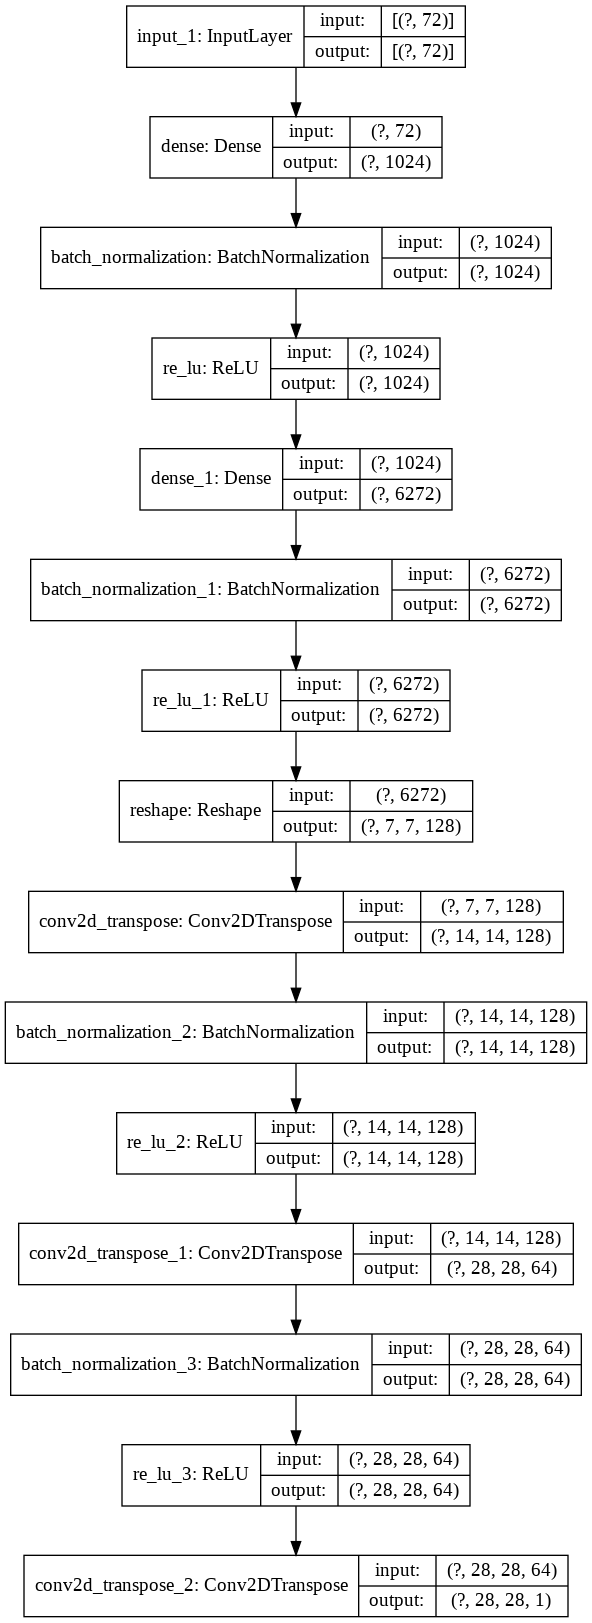

In [ ]:
# Create the generator and plot its structure
g_model = create_generator()
g_model.summary()
keras.utils.plot_model(g_model, to_file="generator.png", show_shapes=True)

#### Discriminator and Auxiliary Model
The discriminator is also the same as the ones in normal GANs. It contains two convolutional layers and two fully-connected layers. The last fully-connected layer generates an output with a “sigmoid” activation function to represent real images (1) or fake images (0).
The auxiliary model shares all layers from the discriminator except for the last fully-connected layer, and thus these two models are defined together. The auxiliary model has two additional fully-connected layers to identify additional information. Since we have one additional input for our generator (a categorical vector), we also need to have one categorical output from the auxiliary model. Thus, I set the last fully-connected layer with a “softmax” activation function.

In [ ]:
def create_discriminator(n_filters=64, n_class=10, input_shape=(28, 28, 1)):
    # Build functional API model
    # Image Input
    image_input = keras.layers.Input(shape=input_shape)

    nf = n_filters
    c_1 = keras.layers.Conv2D(nf, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=True)(image_input)
    bn_1 = keras.layers.BatchNormalization()(c_1)
    act_1 = keras.layers.LeakyReLU(alpha=0.1)(bn_1)

    # Number of filters doubled after each convolutional layer
    nf = nf*2
    # Second convolutional layer
    # Output shape: 7x7
    c_2 = keras.layers.Conv2D(nf, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False)(act_1)
    bn_2 = keras.layers.BatchNormalization()(c_2)
    act_2 = keras.layers.LeakyReLU(alpha=0.1)(bn_2)

    # Flatten the convolutional layers
    flatten = keras.layers.Flatten()(act_2)

    # FC layer
    dense = keras.layers.Dense(1024, use_bias=False)(flatten)
    bn = keras.layers.BatchNormalization()(dense)
    act = keras.layers.LeakyReLU(alpha=0.1)(bn)
    # Discriminator output. Sigmoid activation function to classify "True" or "False"
    d_output = keras.layers.Dense(1, activation='sigmoid')(act)

    # Auxiliary output. 
    q_dense = keras.layers.Dense(128, use_bias=False)(act)
    q_bn = keras.layers.BatchNormalization()(q_dense)
    q_act = keras.layers.LeakyReLU(alpha=0.1)(q_bn)

    # Classification (categorical output)
    clf_out = keras.layers.Dense(n_class, activation="softmax")(q_act)

    # Discriminator model (not compiled)
    d_model = keras.models.Model(inputs=image_input, outputs=d_output)

    # Auxiliary model (not compiled)
    q_model = keras.models.Model(inputs=image_input, outputs=clf_out)
    return d_model, q_model

Summaries for both the discriminator and auxiliary model are shown below:

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1088      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         131072    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

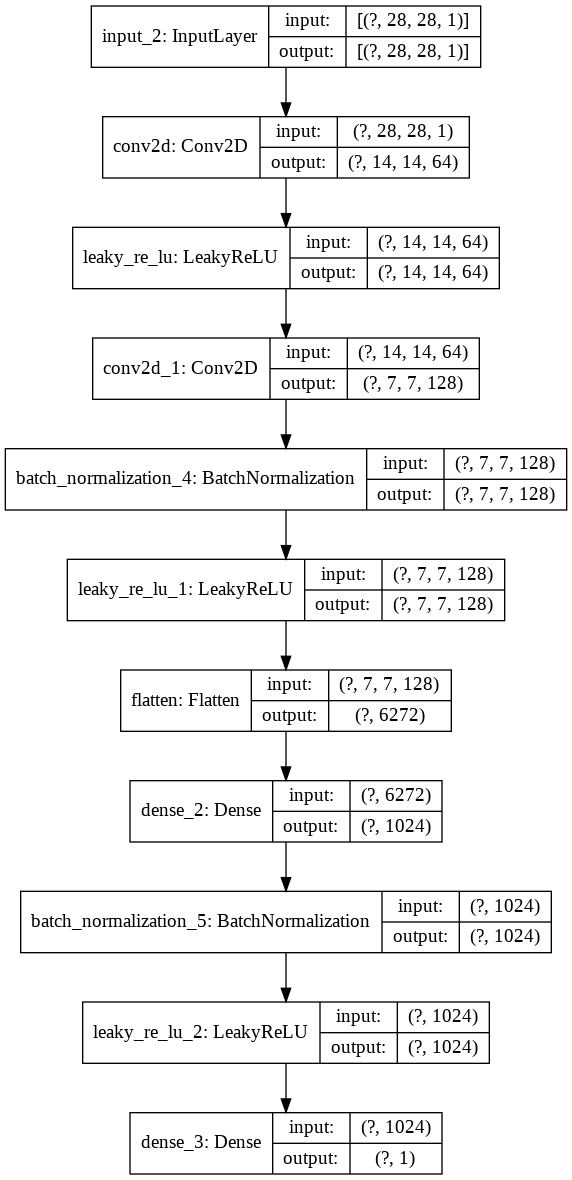

In [ ]:
# Create the discriminator and the auxiliary model
d_model, q_model = create_discriminator()
d_model.summary()
keras.utils.plot_model(d_model, to_file="discriminator.png", show_shapes=True)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1088      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         131072    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

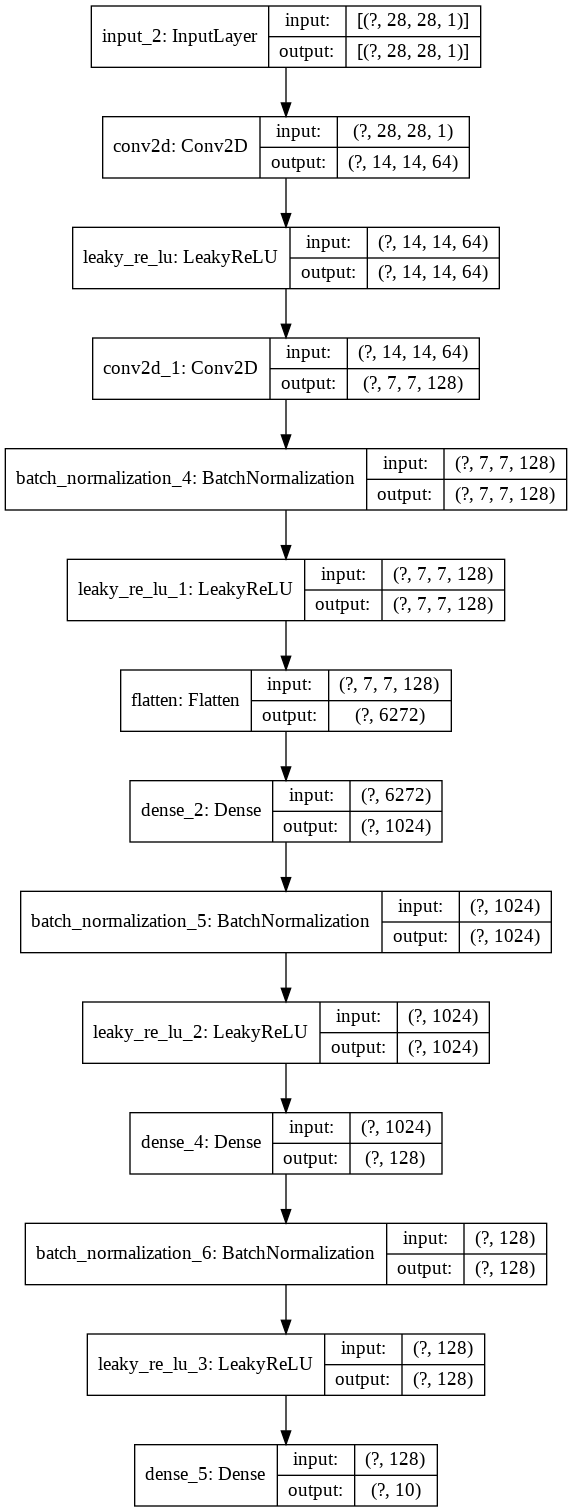

In [ ]:
q_model.summary()
keras.utils.plot_model(q_model, to_file="auxiliary.png", show_shapes=True)

### Training Loop

InfoGAN model is then defined as a class by using Keras API. This allows me to use the Keras built-in methods for training the models such as model.compile, and model.fit. It contains the following sub-units:
- _init__ initializes the model by giving the discriminator, generator, auxiliary model, size of the noise vector, and the number of classes for categorical vector.
- compile function compiles the InfoGAN_Continuous model (for all three optimizers I used Adam).
- create_gen_input is the function that we defined previously to generate inputs for the generator.
- concat_inputs concatenate the three input vectors (size 62, size 10, size 1) into one vector of size 73.
- train_step function defines the training step. It only takes batches of real images. At first, the discriminator is trained by discriminating half-batch of real images and half-batch of fake images. The loss of discriminator is the sum of losses from discriminating both real images and fake images. Weights are updated by gradient descent algorithm based on the loss. Then, the generator and the auxiliary model are trained using full batches of fake images. The auxiliary model loss contains a categorical loss. The categorical loss is just the categorical cross-entropy between the predicted label and the input categorical vector. The generator loss contains both the loss from the discriminator and the loss from the auxiliary model. By doing so, the generator will learn to produce more realistic images with more specific features. Notice that we set the variables in the discriminator to not trainable, as we do not want to modify the neurons in the discriminator when training the generator and the auxiliary model.

In [ ]:
class InfoGAN(keras.Model):
    def __init__(self, d_model, g_model, q_model,noise_size, num_classes):
        super(InfoGAN, self).__init__()
        self.d_model = d_model
        self.g_model = g_model
        self.q_model = q_model
        self.noise_size = noise_size
        self.num_classes = num_classes

    def compile(self, d_optimizer, g_optimizer, q_optimizer):
        super(InfoGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.q_optimizer = q_optimizer

    def create_gen_input(self, batch_size, noise_size, n_class, seed=None):
        # create noise input
        noise = tf.random.normal([batch_size, noise_size], seed=seed)
        # Create categorical latent code
        label = tf.random.uniform([batch_size], minval=0, maxval=10, dtype=tf.int32, seed=seed)
        label = tf.one_hot(label, depth=n_class)
        return label, noise

    def concat_inputs(self, input):
        concat_input = keras.layers.Concatenate()(input)
        return concat_input

    def train_step(self, real_image_batch):
        # Define loss functions
        binary_loss = keras.losses.BinaryCrossentropy()
        categorical_loss = keras.losses.CategoricalCrossentropy()
        # Half-batch for training discriminator and batch for training GAN
        batch = tf.shape(real_image_batch)[0]
        # batch = batch * 2
        # Create generator input 
        g_label, g_noise = self.create_gen_input(batch, self.noise_size, self.num_classes, seed=None)
        g_input = self.concat_inputs([g_label, g_noise])
        with tf.GradientTape() as d_tape: 
            self.d_model.trainable = True
            d_tape.watch(self.d_model.trainable_variables)
            # Train discriminator using half batch real images
            y_disc_real = tf.ones((batch, 1))
            d_real_output = self.d_model(real_image_batch, training=True)
            d_loss_real = binary_loss(y_disc_real, d_real_output)
            # Train discriminator using half batch fake images     
            y_disc_fake = tf.zeros((batch, 1))
            # Create fake image batch
            fake_image_batch = self.g_model(g_input, training=True)
            d_fake_output = self.d_model(fake_image_batch, training=True)
            d_loss_fake = binary_loss(y_disc_fake, d_fake_output)
            d_loss = d_loss_real + d_loss_fake
        # Calculate gradients
        d_gradients = d_tape.gradient(d_loss, self.d_model.trainable_variables)
        # Optimize
        self.d_optimizer.apply_gradients(zip(d_gradients, self.d_model.trainable_variables))
        with tf.GradientTape() as g_tape, tf.GradientTape() as q_tape:
            # Create generator input 
            g_label, g_noise = self.create_gen_input(batch*2, self.noise_size, self.num_classes, seed=None)
            g_input = self.concat_inputs([g_label, g_noise])
            g_tape.watch(self.g_model.trainable_variables)
            q_tape.watch(self.q_model.trainable_variables)
            # Create fake image batch
            fake_image_batch = self.g_model(g_input, training=True)
            d_fake_output = self.d_model(fake_image_batch, training=True)
            # Generator Image loss
            y_gen_fake = tf.ones((batch*2, 1))
            g_img_loss = binary_loss(y_gen_fake, d_fake_output)
            # Auxiliary loss
            q_output = self.q_model(fake_image_batch, training=True)
            cat_output = q_output
            # Categorical loss
            cat_loss = categorical_loss(g_label, cat_output)
            # Generator total loss
            eta = 1
            g_loss = g_img_loss + eta * cat_loss
            # Auxiliary function loss
            q_loss = eta * cat_loss
        # Calculate gradients
        self.d_model.trainable=False
        g_gradients = g_tape.gradient(g_loss, self.g_model.trainable_variables)
        q_gradients = q_tape.gradient(q_loss, self.q_model.trainable_variables)
        # Optimize
        self.g_optimizer.apply_gradients(zip(g_gradients, self.g_model.trainable_variables))
        self.q_optimizer.apply_gradients(zip(q_gradients, self.q_model.trainable_variables))

        return {"d_loss_real": d_loss_real, "d_loss_fake": d_loss_fake, "g_img_loss": g_img_loss ,
                "cat_loss": cat_loss}

I also defined a customized callback function that can help me print out and save images generated by the generator after each epoch, and a checkpoint callback function that can save the model checkpoints.

In [ ]:
class GenerateAndSaveImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # This callback displays the generated images after every epoch to track the performance of the model
        if (epoch+1) % 1 == 0:
          # Create new images based on random input
          # We will reuse this seed overtime, so it's easier to visualize the progress of the training
            tf.random.set_seed(0)
            noise = tf.random.normal([62])
            noise_test = []
            for _ in range(10):
                noise_test.append(noise)
                tf.random.set_seed(1)
                noise = tf.random.normal([62])
            for _ in range(10):
                noise_test.append(noise)
                noise_test = np.array(noise_test)
                label_test = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                label_test = tf.one_hot(label_test, depth=10)
                test_input = keras.layers.Concatenate()([label_test, noise_test])
                predictions = self.model.g_model.predict(test_input)
                fig = plt.figure(figsize=(16,16))

            for i in range(predictions.shape[0]):
                ax = fig.add_subplot(5, 5, i+1)
                ax.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title("label: {}".format(np.argmax(label_test[i])))  

            plt.savefig('/content/drive/My Drive/Machine Learning/GAN_MNIST/Images/image_at_epoch_{:03d}.png'.format(epoch+1))
            plt.show()


In [ ]:
checkpoint_dir = "/content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 verbose=1)
image_callback = GenerateAndSaveImages()

In [ ]:
# Create models
g_model = create_generator()
d_model, q_model = create_discriminator()

In [ ]:
infogan = InfoGAN(d_model, g_model, q_model, noise_size=62, num_classes=10)
infogan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=2e-4),
                g_optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                q_optimizer=keras.optimizers.Adam(learning_rate=2e-4))

Restore the training after disconnected:

In [ ]:
infogan.load_weights(checkpoint_dir)

This function loads the MNIST hand-written digits from keras datasets:

In [ ]:
def load_real_image(batch_size=32):
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
    # Add the color channel - change to 4D tensor, and convert the data type to 'float32'
    train_images = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
    # Set the pixel values from -1 to 1
    train_images = (train_images/255.0) * 2 - 1
    # Shuffle and separate in batch
    buffer_size = train_images.shape[0]
    train_images_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)
    return train_images_dataset

**Now, let's start training!**

Epoch 1/40
1872/1875 [============================>.] - ETA: 0s - d_loss_real: 0.5567 - d_loss_fake: 0.5462 - g_img_loss: 1.0168 - cat_loss: 0.1221

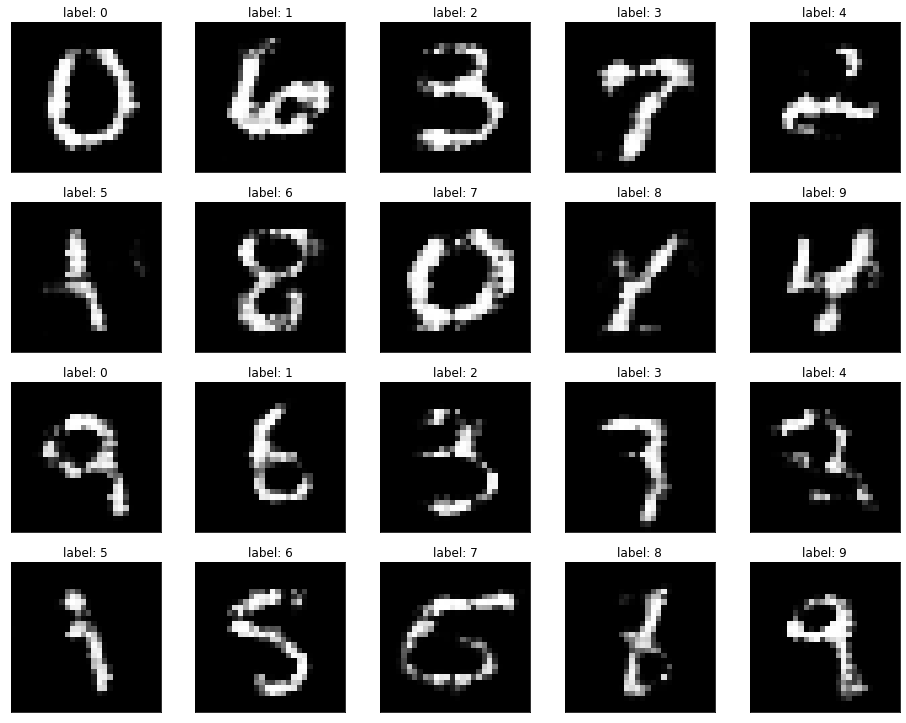


Epoch 00001: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.5569 - d_loss_fake: 0.5463 - g_img_loss: 1.0164 - cat_loss: 0.1219
Epoch 2/40
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.6362 - d_loss_fake: 0.6307 - g_img_loss: 0.8434 - cat_loss: 0.0282

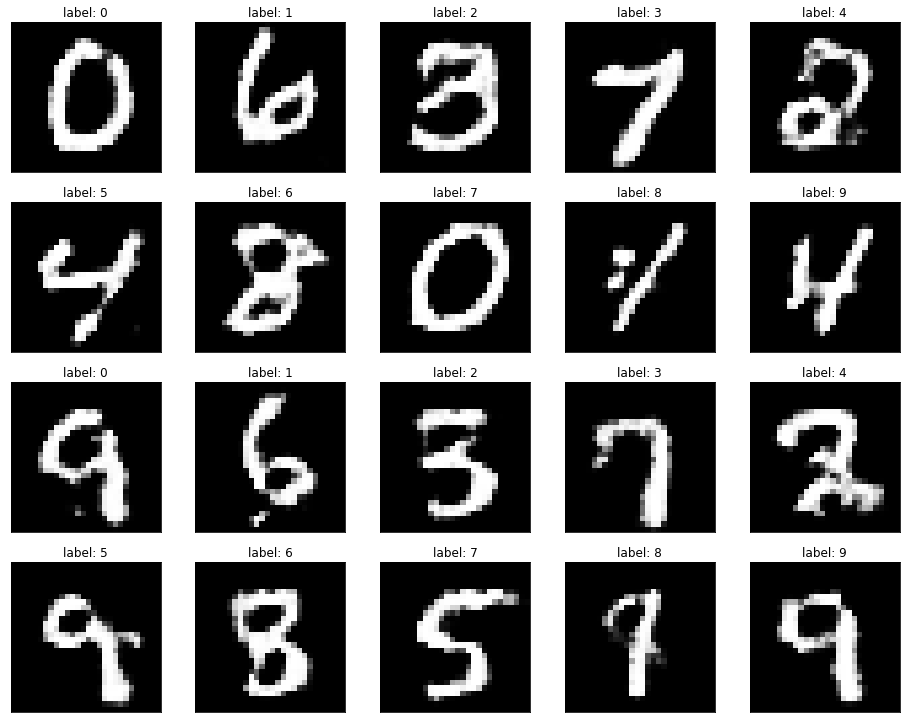


Epoch 00002: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.6361 - d_loss_fake: 0.6306 - g_img_loss: 0.8434 - cat_loss: 0.0282
Epoch 3/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.6473 - d_loss_fake: 0.6423 - g_img_loss: 0.8173 - cat_loss: 0.0205

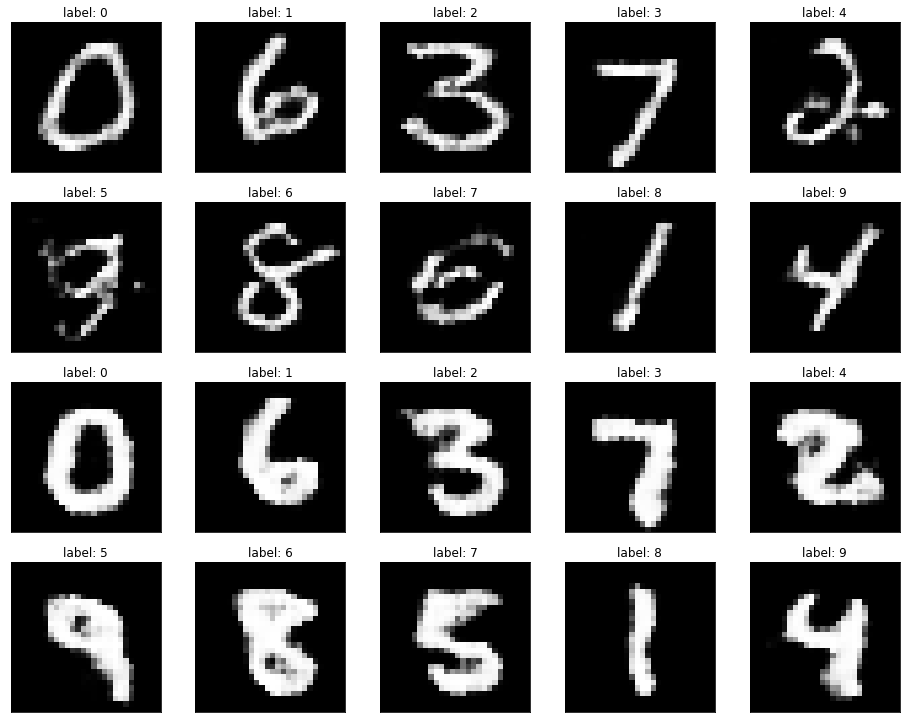


Epoch 00003: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 34s 18ms/step - d_loss_real: 0.6473 - d_loss_fake: 0.6422 - g_img_loss: 0.8173 - cat_loss: 0.0205
Epoch 4/40
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.6649 - d_loss_fake: 0.6598 - g_img_loss: 0.7891 - cat_loss: 0.0119

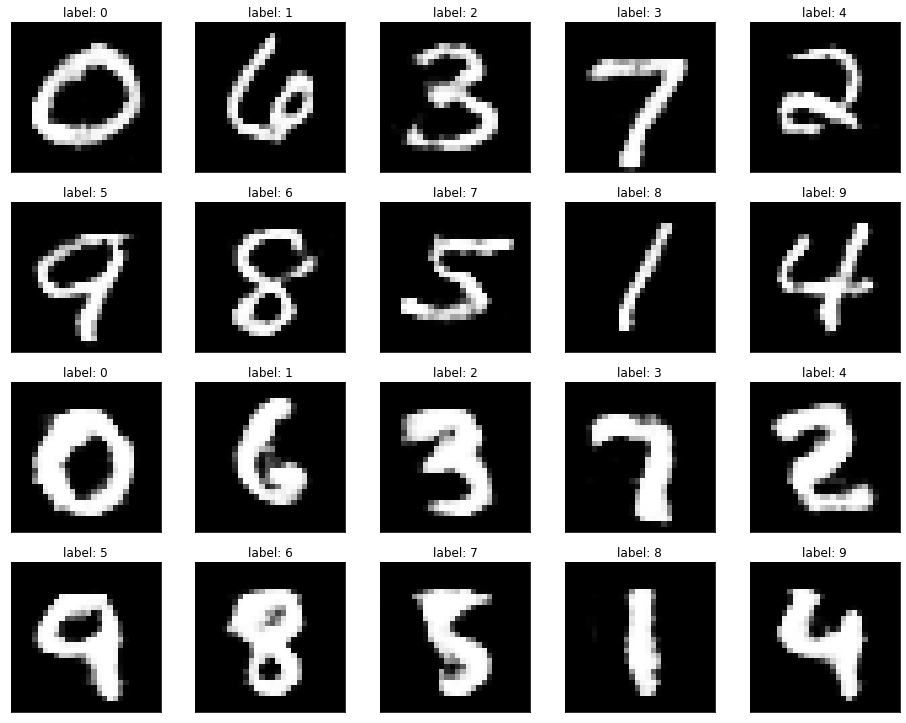


Epoch 00004: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.6649 - d_loss_fake: 0.6599 - g_img_loss: 0.7891 - cat_loss: 0.0119
Epoch 5/40
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.6688 - d_loss_fake: 0.6649 - g_img_loss: 0.7735 - cat_loss: 0.0093

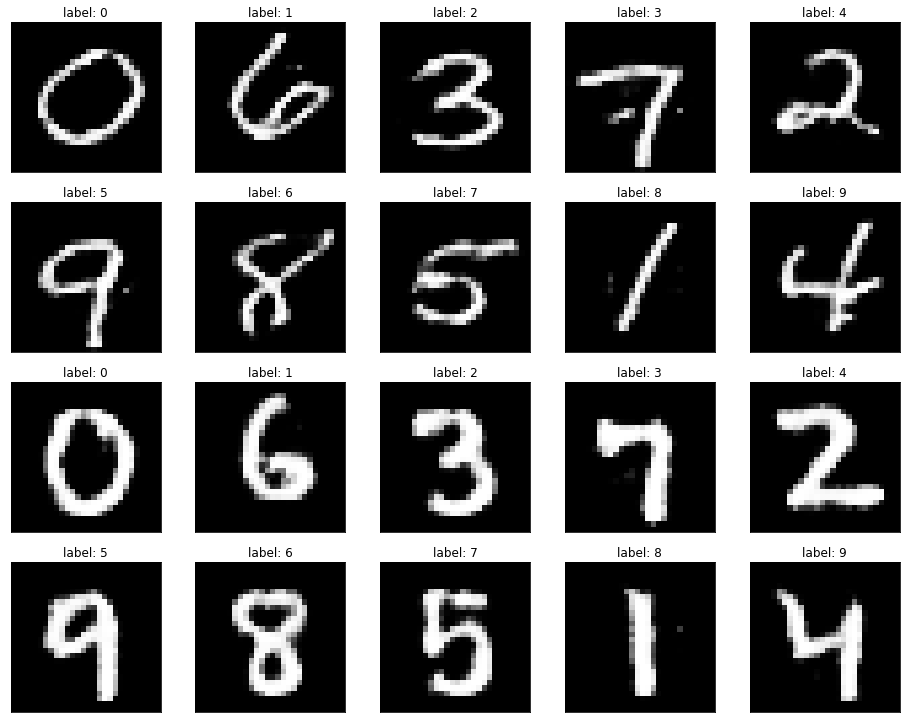


Epoch 00005: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.6688 - d_loss_fake: 0.6649 - g_img_loss: 0.7734 - cat_loss: 0.0093
Epoch 6/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.6679 - d_loss_fake: 0.6645 - g_img_loss: 0.7689 - cat_loss: 0.0085

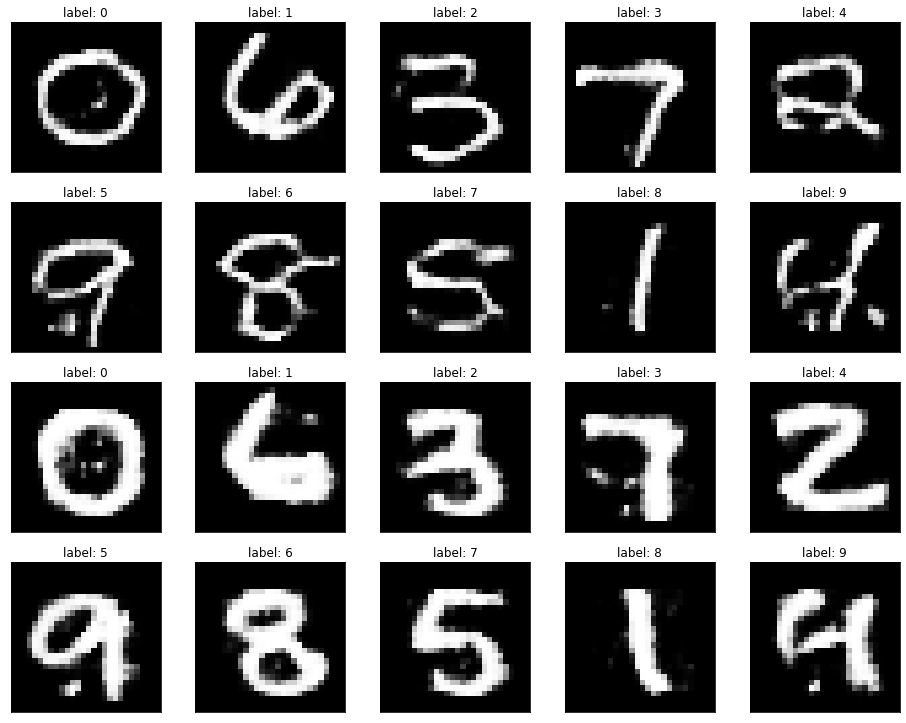


Epoch 00006: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.6680 - d_loss_fake: 0.6645 - g_img_loss: 0.7689 - cat_loss: 0.0085
Epoch 7/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.6673 - d_loss_fake: 0.6651 - g_img_loss: 0.7699 - cat_loss: 0.0069

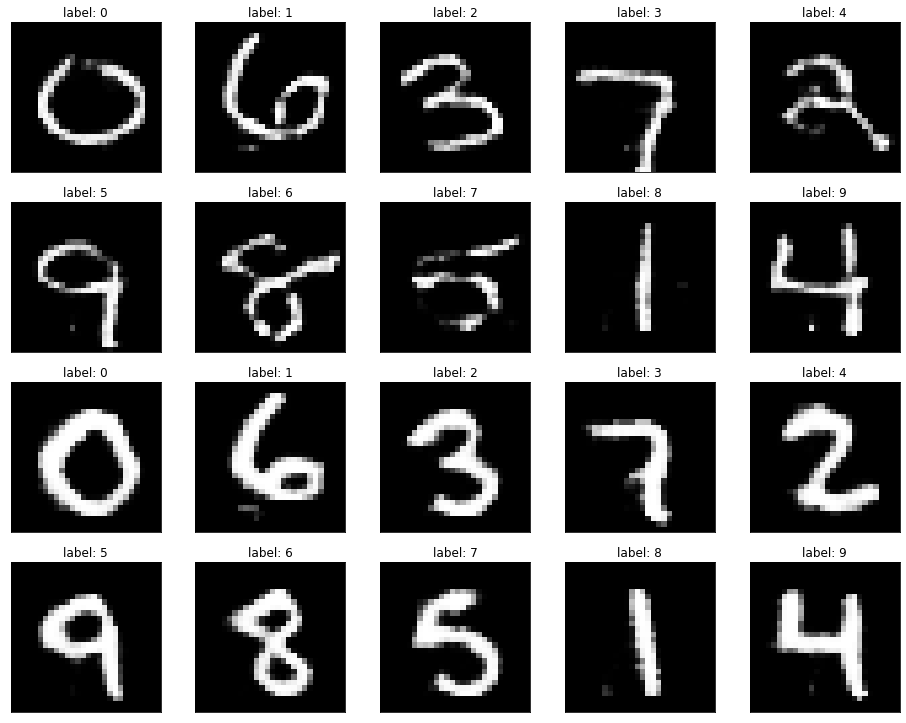


Epoch 00007: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.6673 - d_loss_fake: 0.6651 - g_img_loss: 0.7699 - cat_loss: 0.0069
Epoch 8/40
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.6600 - d_loss_fake: 0.6575 - g_img_loss: 0.7803 - cat_loss: 0.0066

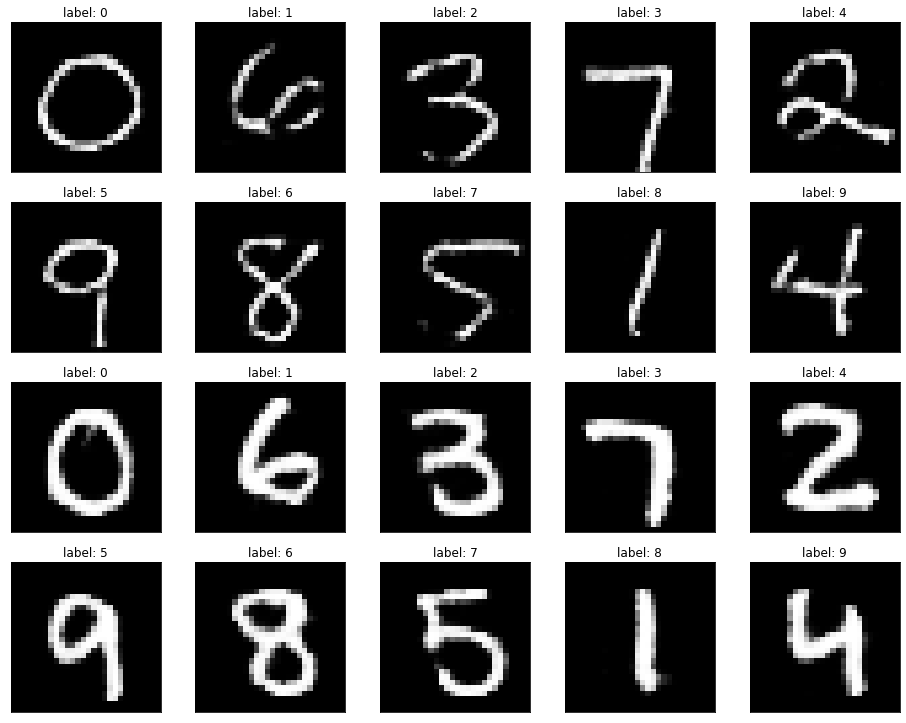


Epoch 00008: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.6601 - d_loss_fake: 0.6575 - g_img_loss: 0.7803 - cat_loss: 0.0066
Epoch 9/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.6525 - d_loss_fake: 0.6503 - g_img_loss: 0.7916 - cat_loss: 0.0068

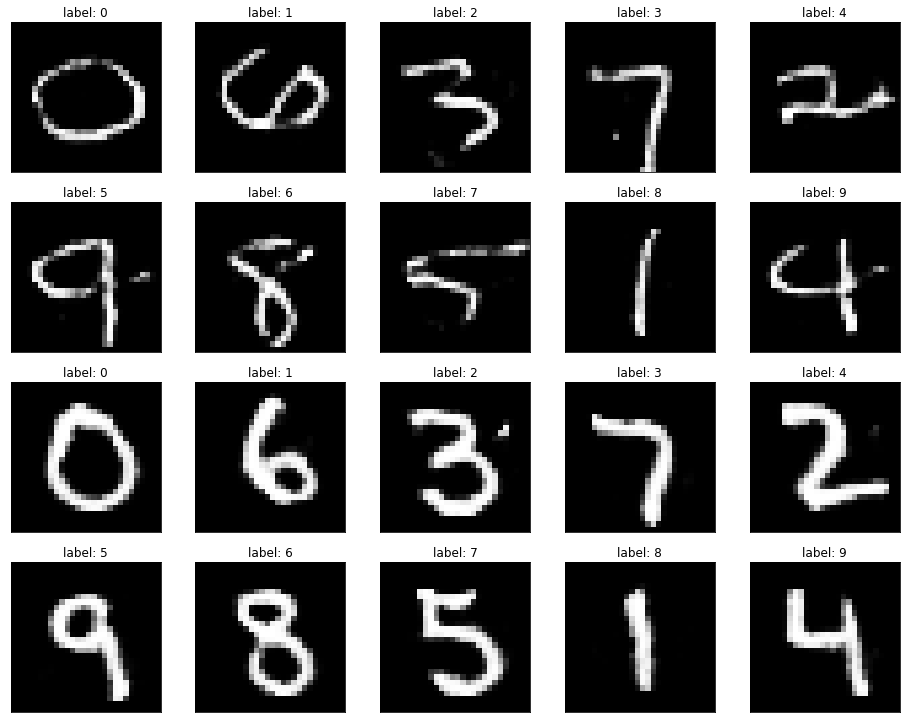


Epoch 00009: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.6525 - d_loss_fake: 0.6503 - g_img_loss: 0.7916 - cat_loss: 0.0068
Epoch 10/40
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.6440 - d_loss_fake: 0.6423 - g_img_loss: 0.8093 - cat_loss: 0.0061

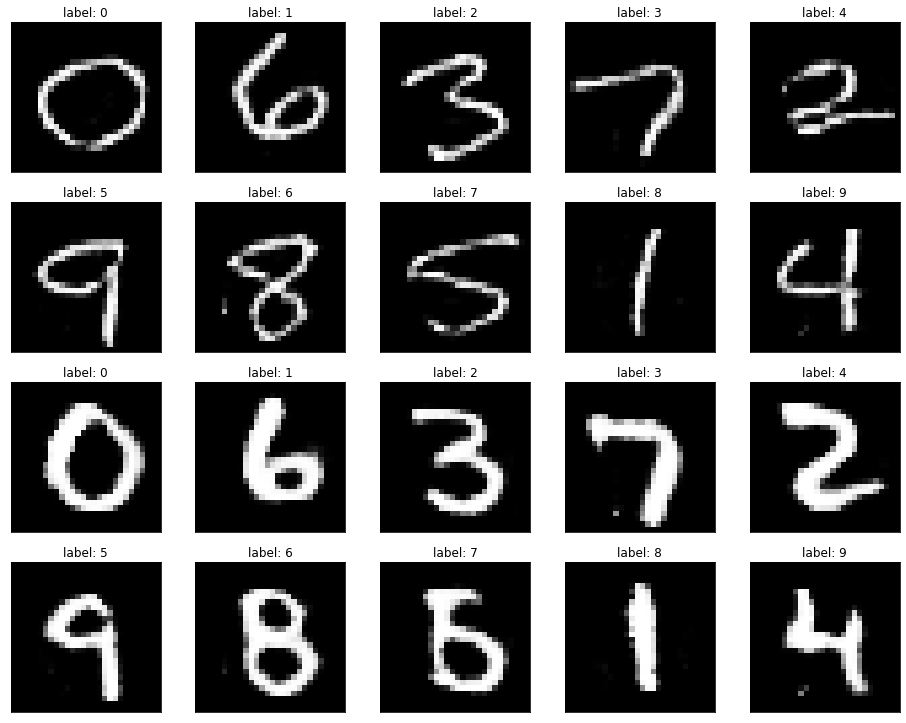


Epoch 00010: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.6441 - d_loss_fake: 0.6422 - g_img_loss: 0.8095 - cat_loss: 0.0061
Epoch 11/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.6342 - d_loss_fake: 0.6324 - g_img_loss: 0.8334 - cat_loss: 0.0074

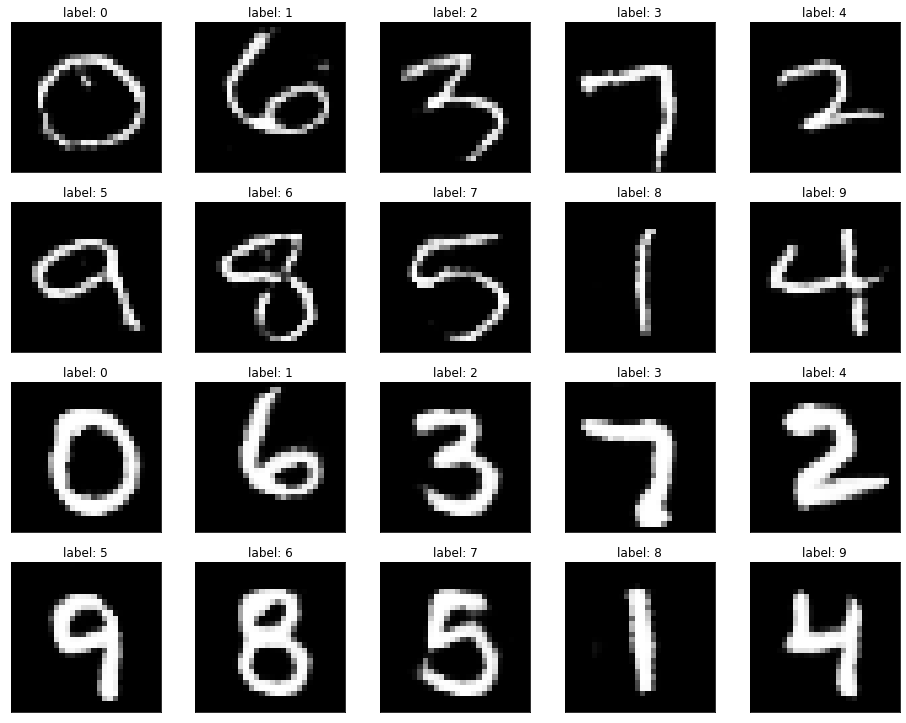


Epoch 00011: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.6342 - d_loss_fake: 0.6325 - g_img_loss: 0.8334 - cat_loss: 0.0074
Epoch 12/40
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.6256 - d_loss_fake: 0.6240 - g_img_loss: 0.8554 - cat_loss: 0.0070

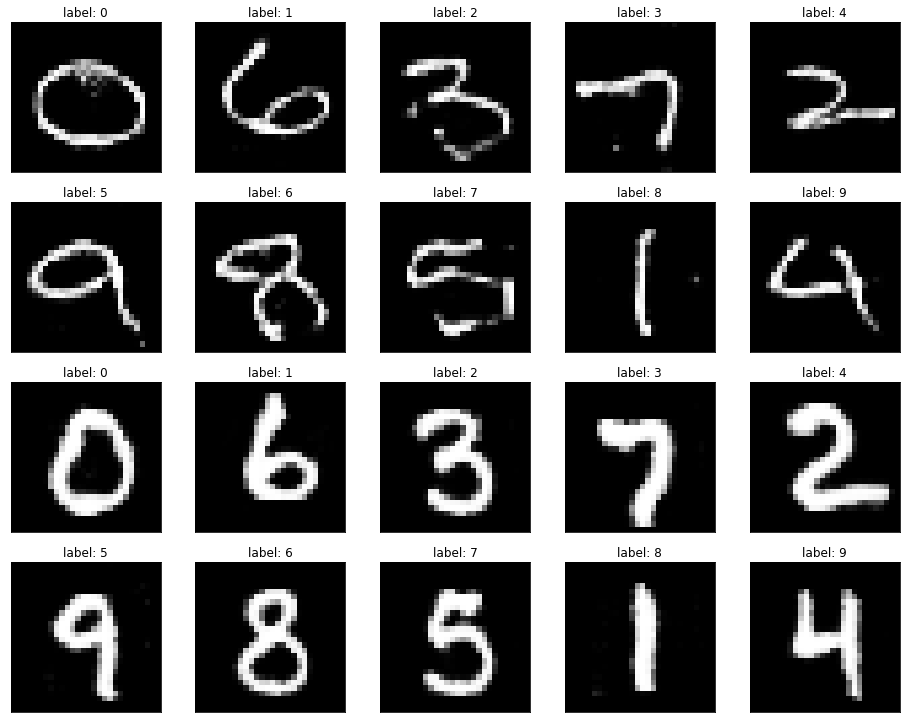


Epoch 00012: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 34s 18ms/step - d_loss_real: 0.6255 - d_loss_fake: 0.6241 - g_img_loss: 0.8552 - cat_loss: 0.0070
Epoch 13/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.6179 - d_loss_fake: 0.6158 - g_img_loss: 0.8791 - cat_loss: 0.0069

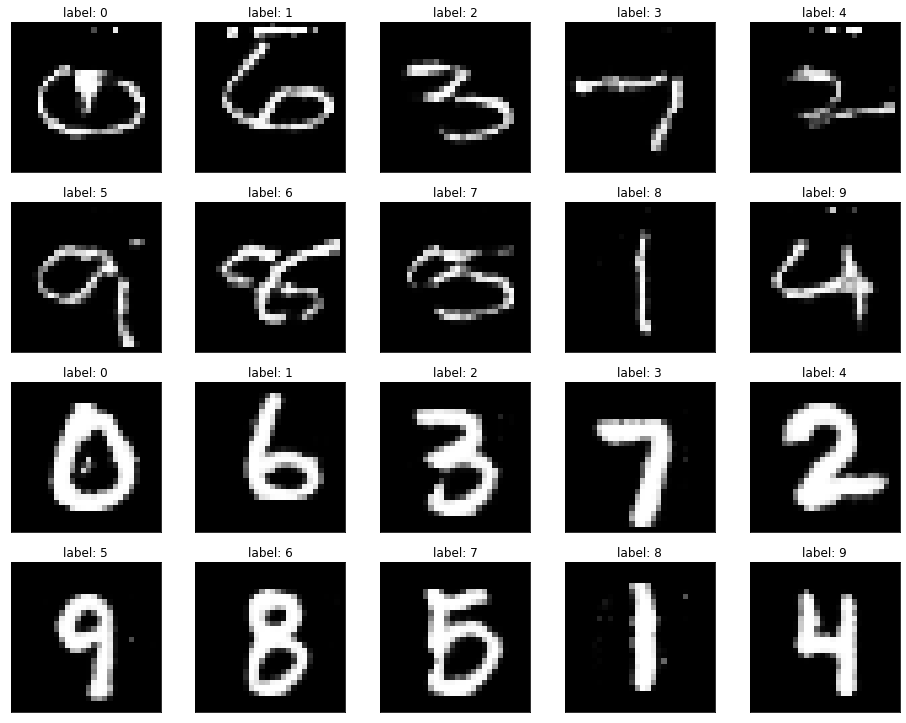


Epoch 00013: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.6180 - d_loss_fake: 0.6159 - g_img_loss: 0.8791 - cat_loss: 0.0069
Epoch 14/40
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.6060 - d_loss_fake: 0.6058 - g_img_loss: 0.9068 - cat_loss: 0.0066

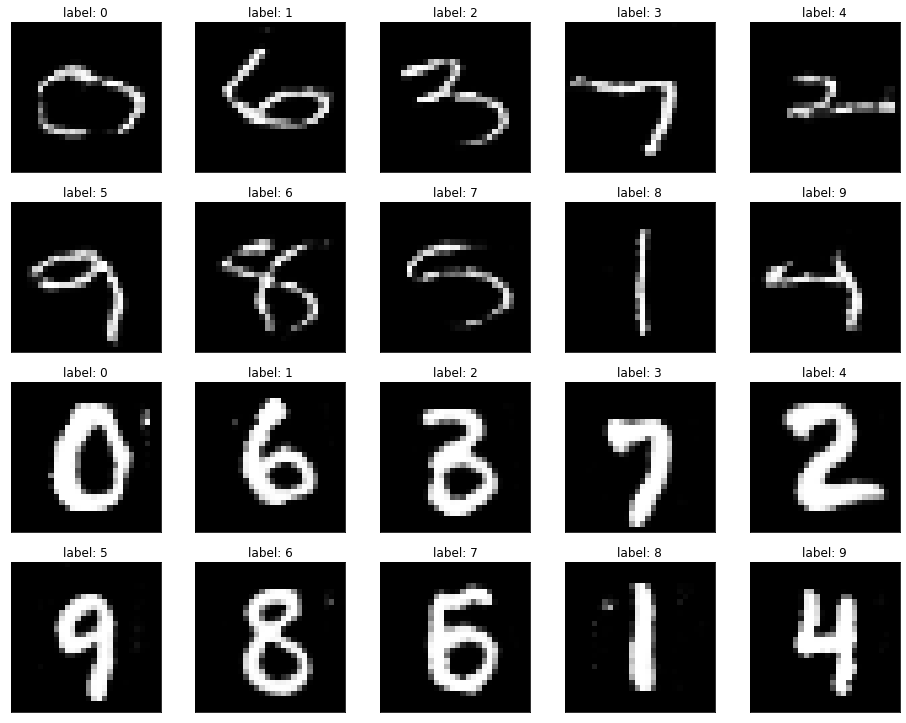


Epoch 00014: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.6060 - d_loss_fake: 0.6057 - g_img_loss: 0.9069 - cat_loss: 0.0066
Epoch 15/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.6006 - d_loss_fake: 0.6000 - g_img_loss: 0.9302 - cat_loss: 0.0069

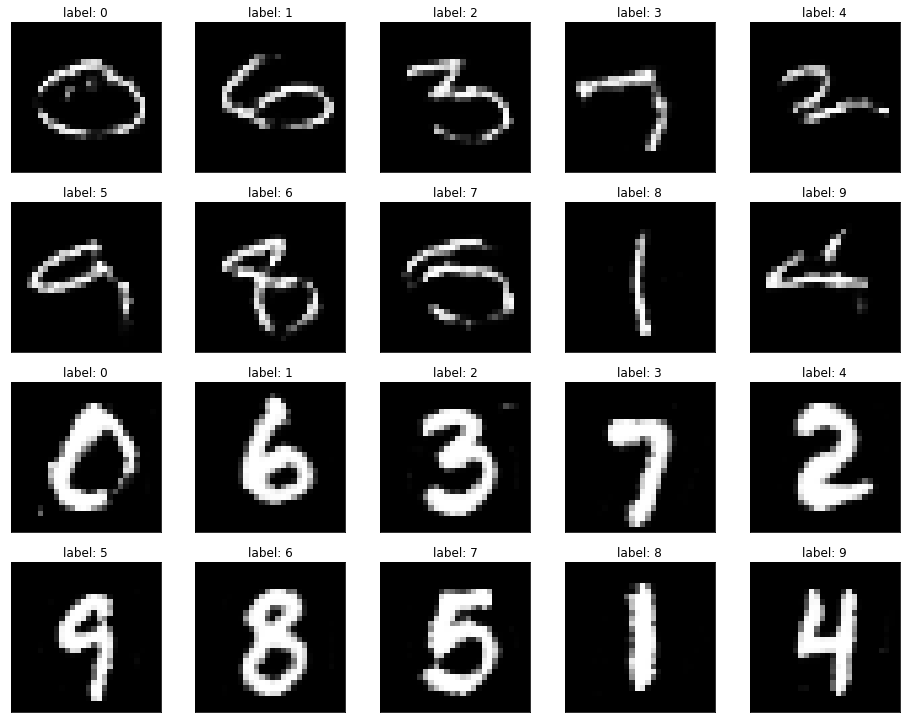


Epoch 00015: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.6007 - d_loss_fake: 0.6001 - g_img_loss: 0.9301 - cat_loss: 0.0069
Epoch 16/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.5945 - d_loss_fake: 0.5953 - g_img_loss: 0.9466 - cat_loss: 0.0078

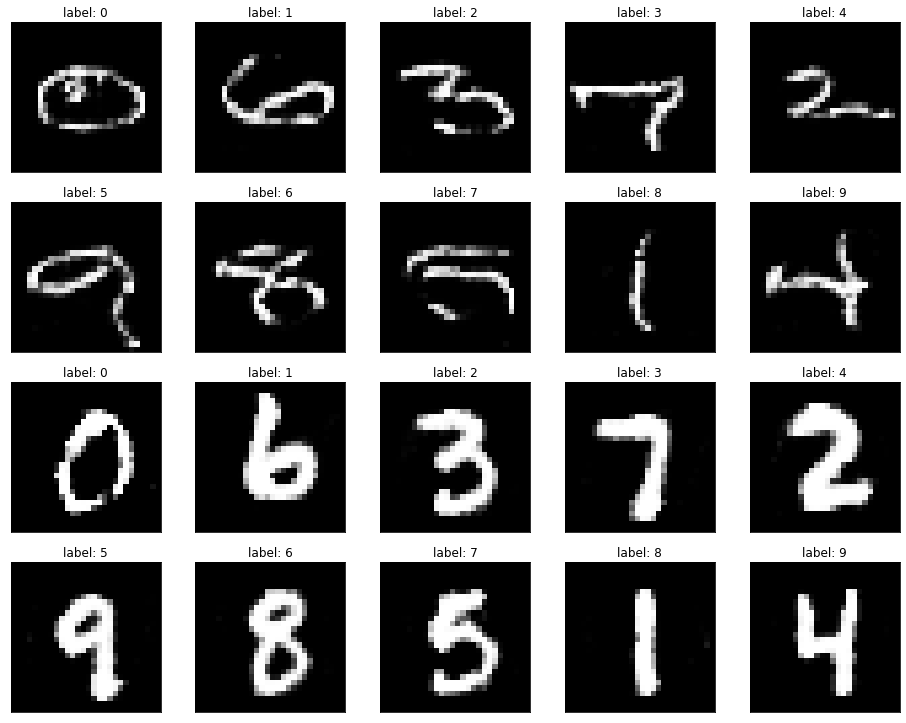


Epoch 00016: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.5945 - d_loss_fake: 0.5952 - g_img_loss: 0.9467 - cat_loss: 0.0079
Epoch 17/40
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.5853 - d_loss_fake: 0.5860 - g_img_loss: 0.9642 - cat_loss: 0.0069

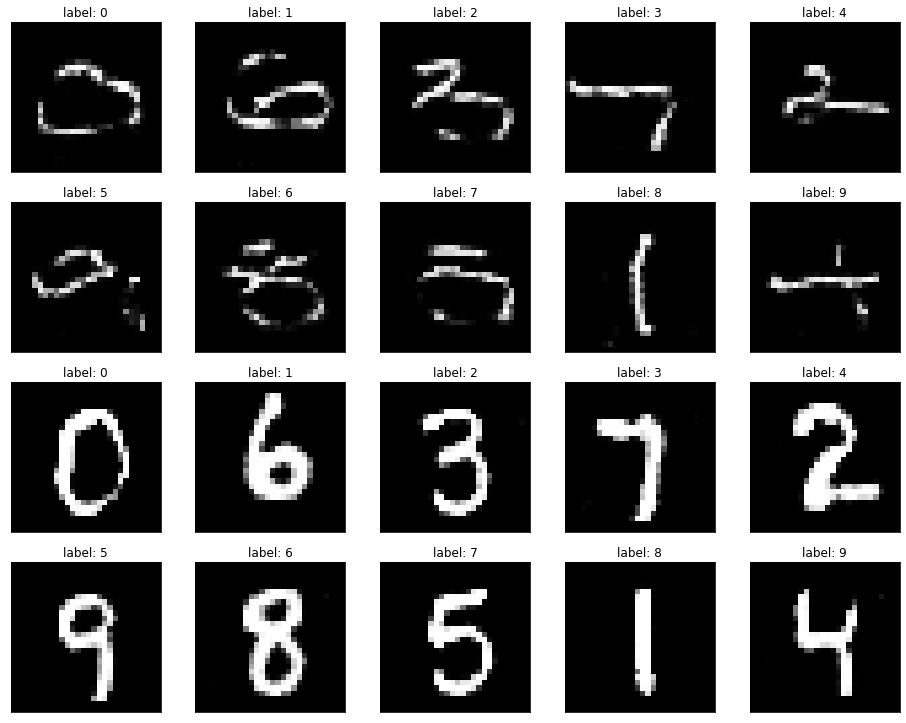


Epoch 00017: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.5856 - d_loss_fake: 0.5861 - g_img_loss: 0.9644 - cat_loss: 0.0069
Epoch 18/40
1872/1875 [============================>.] - ETA: 0s - d_loss_real: 0.5761 - d_loss_fake: 0.5769 - g_img_loss: 1.0023 - cat_loss: 0.0075

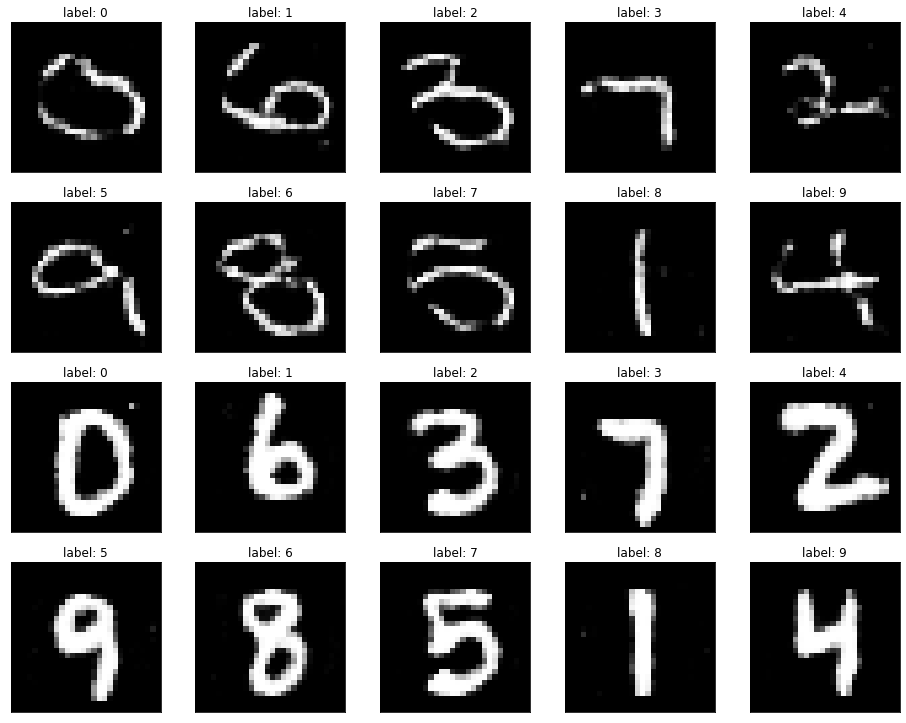


Epoch 00018: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.5762 - d_loss_fake: 0.5768 - g_img_loss: 1.0022 - cat_loss: 0.0075
Epoch 19/40
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.5652 - d_loss_fake: 0.5677 - g_img_loss: 1.0319 - cat_loss: 0.0075

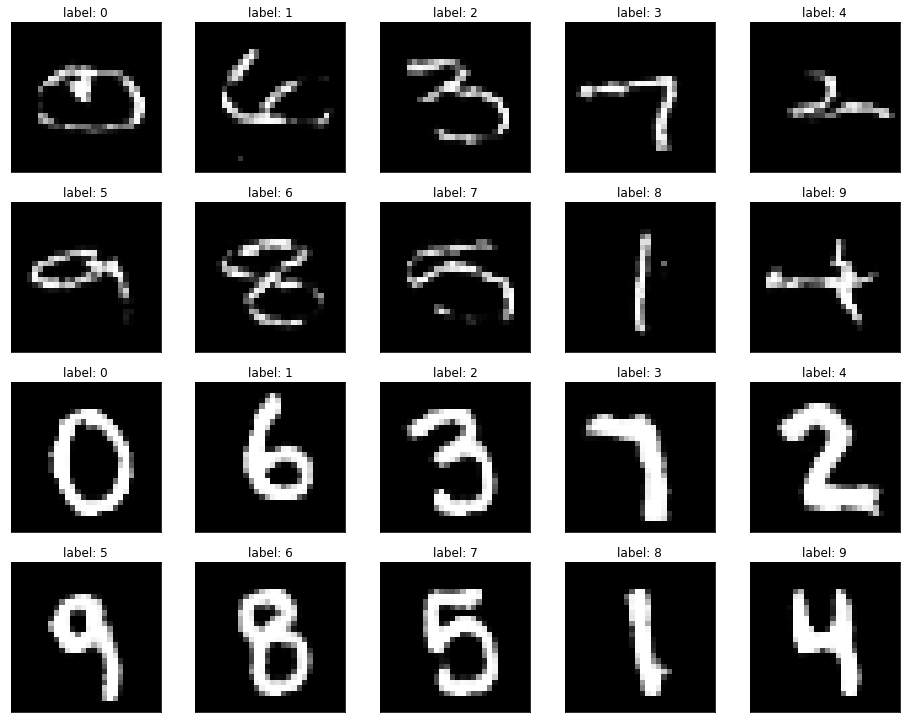


Epoch 00019: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.5652 - d_loss_fake: 0.5677 - g_img_loss: 1.0318 - cat_loss: 0.0075
Epoch 20/40
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.5587 - d_loss_fake: 0.5608 - g_img_loss: 1.0576 - cat_loss: 0.0078

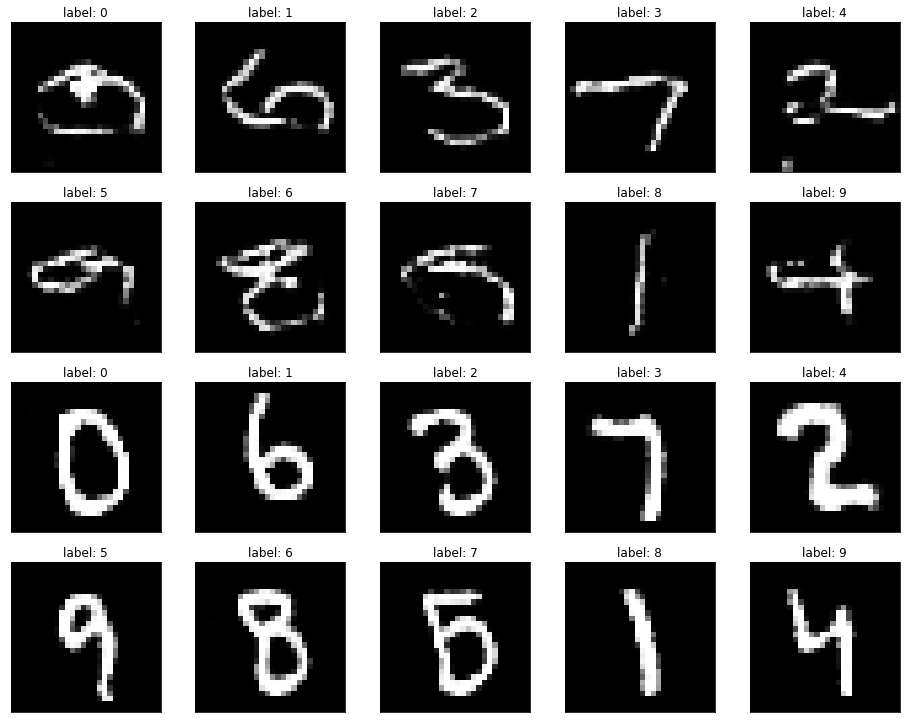


Epoch 00020: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.5586 - d_loss_fake: 0.5608 - g_img_loss: 1.0577 - cat_loss: 0.0078
Epoch 21/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.5476 - d_loss_fake: 0.5491 - g_img_loss: 1.0923 - cat_loss: 0.0074

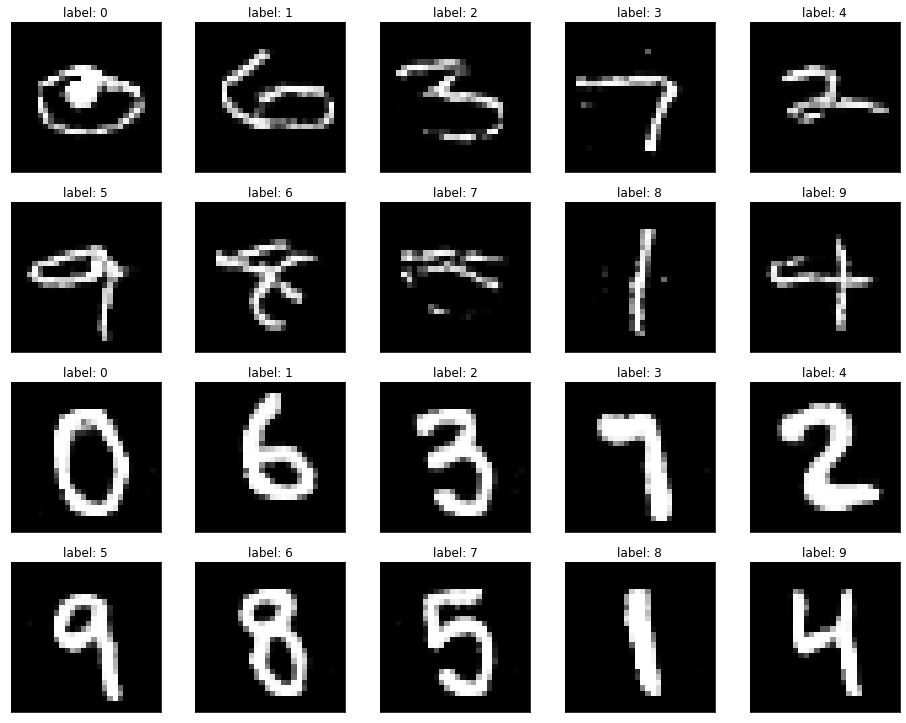


Epoch 00021: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 34s 18ms/step - d_loss_real: 0.5474 - d_loss_fake: 0.5492 - g_img_loss: 1.0921 - cat_loss: 0.0074
Epoch 22/40
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.5394 - d_loss_fake: 0.5420 - g_img_loss: 1.1185 - cat_loss: 0.0071

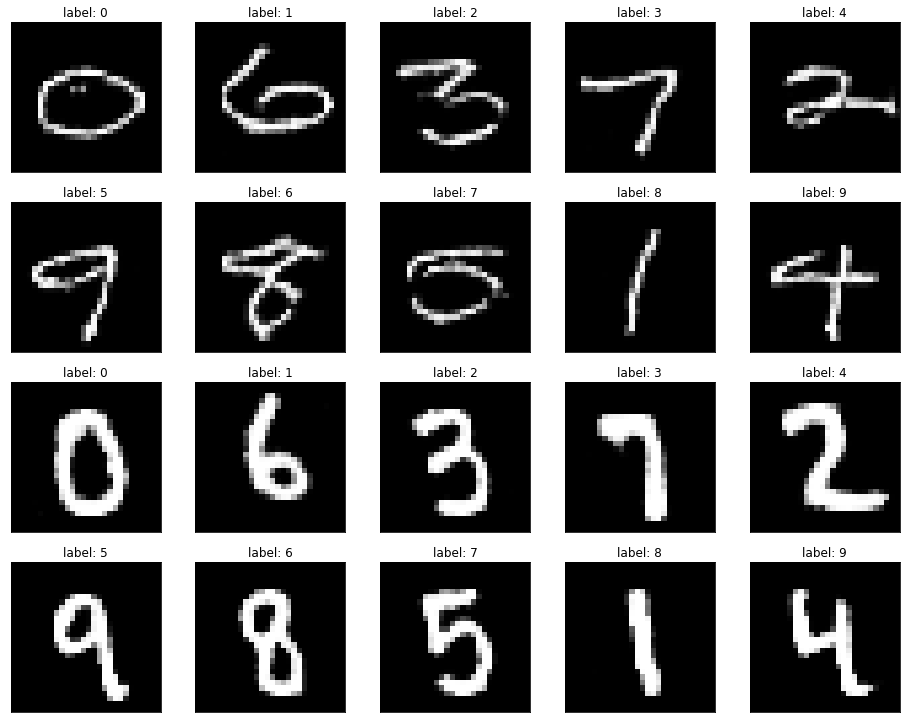


Epoch 00022: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 34s 18ms/step - d_loss_real: 0.5394 - d_loss_fake: 0.5419 - g_img_loss: 1.1186 - cat_loss: 0.0071
Epoch 23/40
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.5294 - d_loss_fake: 0.5339 - g_img_loss: 1.1530 - cat_loss: 0.0072

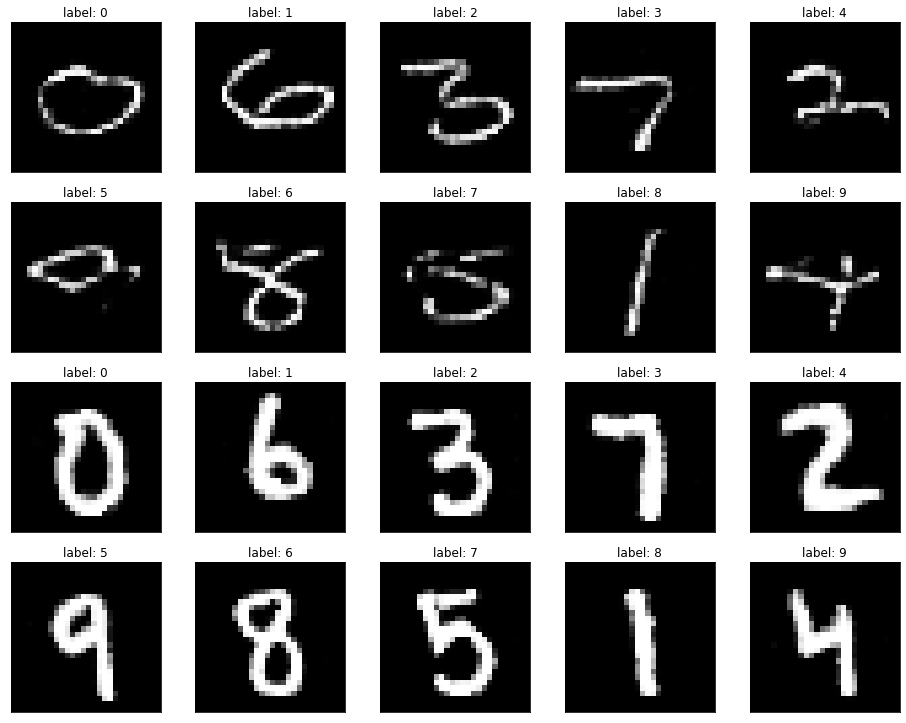


Epoch 00023: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.5294 - d_loss_fake: 0.5339 - g_img_loss: 1.1530 - cat_loss: 0.0072
Epoch 24/40
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.5229 - d_loss_fake: 0.5268 - g_img_loss: 1.1901 - cat_loss: 0.0070

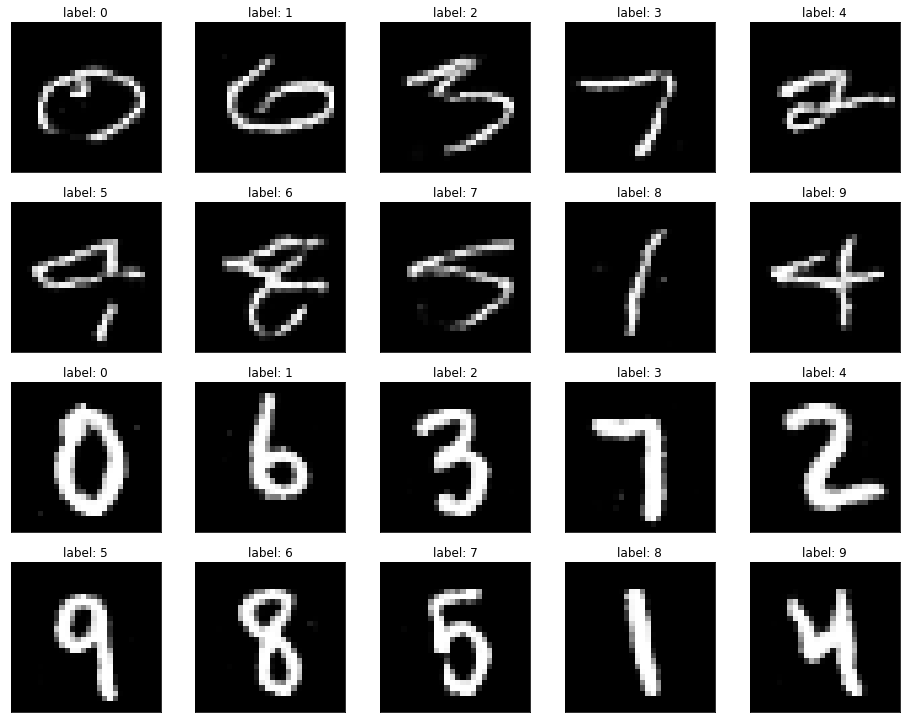


Epoch 00024: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.5228 - d_loss_fake: 0.5268 - g_img_loss: 1.1902 - cat_loss: 0.0070
Epoch 25/40
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.5147 - d_loss_fake: 0.5185 - g_img_loss: 1.2143 - cat_loss: 0.0070

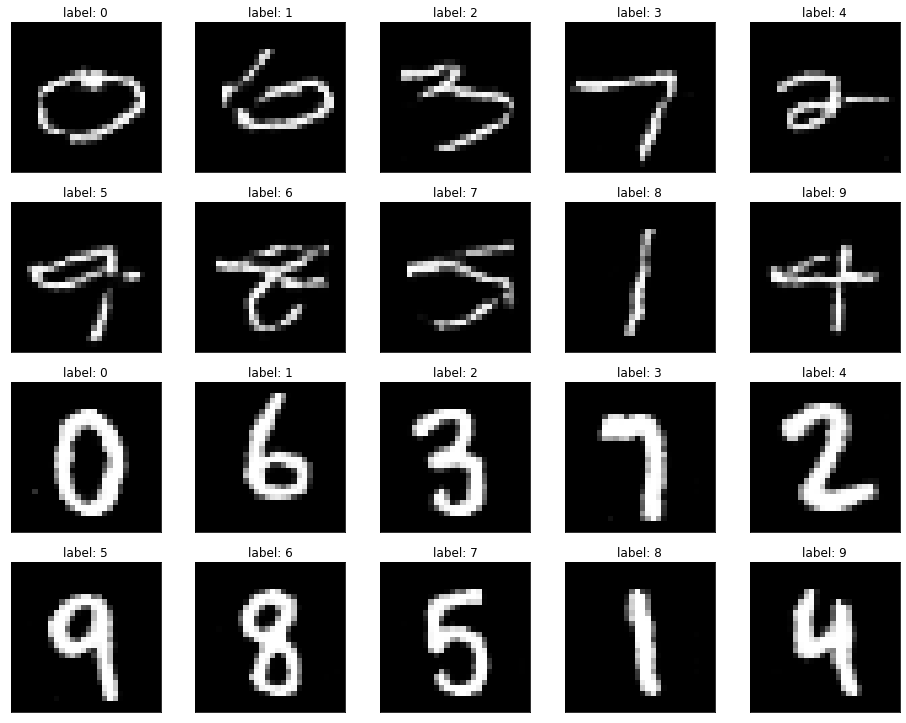


Epoch 00025: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.5145 - d_loss_fake: 0.5185 - g_img_loss: 1.2143 - cat_loss: 0.0070
Epoch 26/40
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.5071 - d_loss_fake: 0.5121 - g_img_loss: 1.2442 - cat_loss: 0.0075

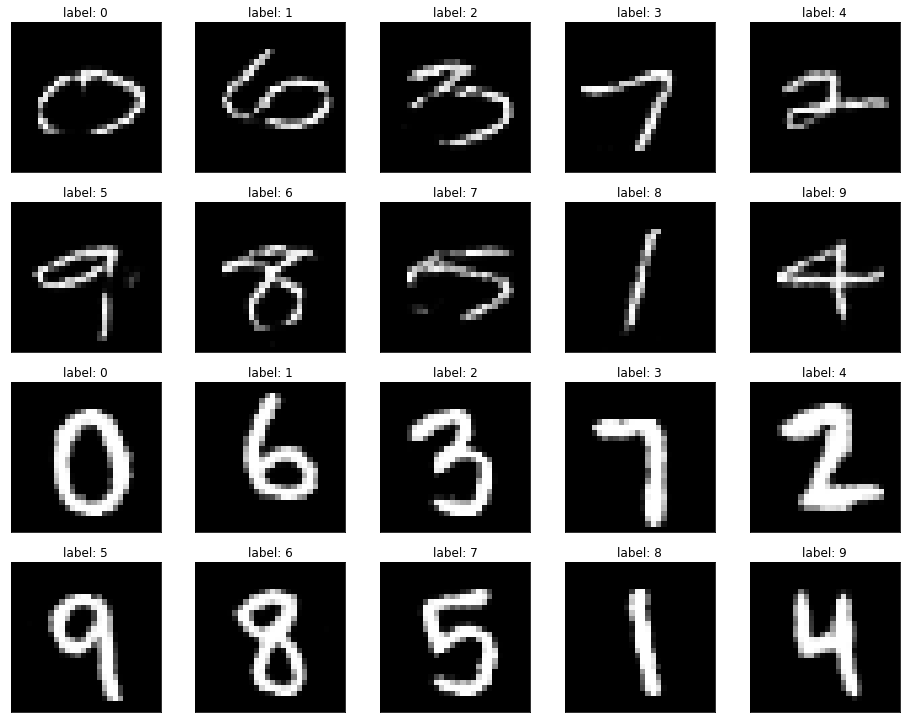


Epoch 00026: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.5070 - d_loss_fake: 0.5121 - g_img_loss: 1.2442 - cat_loss: 0.0075
Epoch 27/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.4960 - d_loss_fake: 0.5004 - g_img_loss: 1.2741 - cat_loss: 0.0080

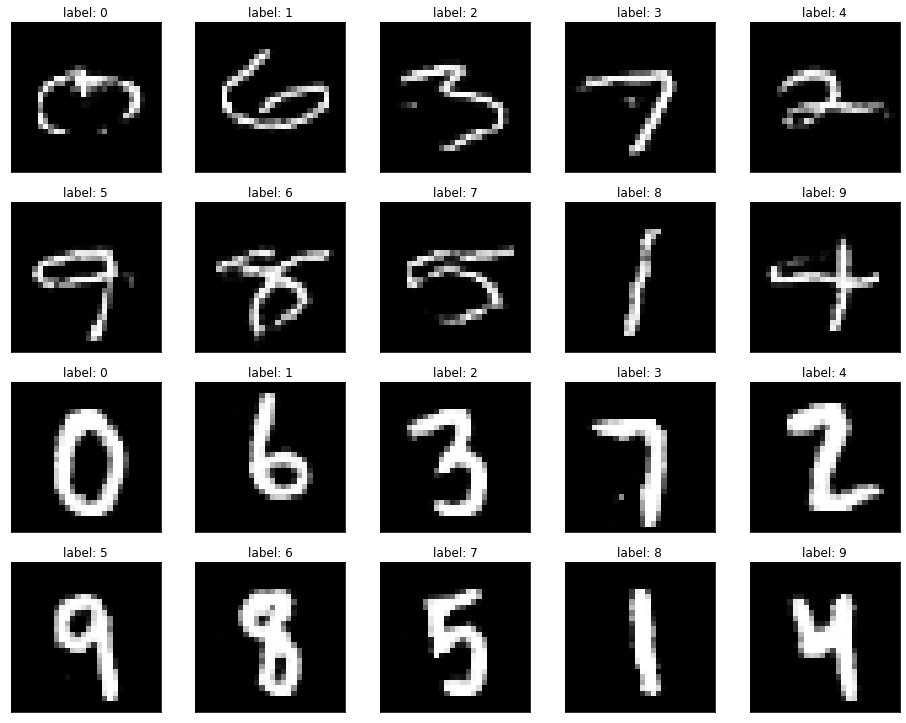


Epoch 00027: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.4959 - d_loss_fake: 0.5003 - g_img_loss: 1.2740 - cat_loss: 0.0080
Epoch 28/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.4903 - d_loss_fake: 0.4970 - g_img_loss: 1.3106 - cat_loss: 0.0075

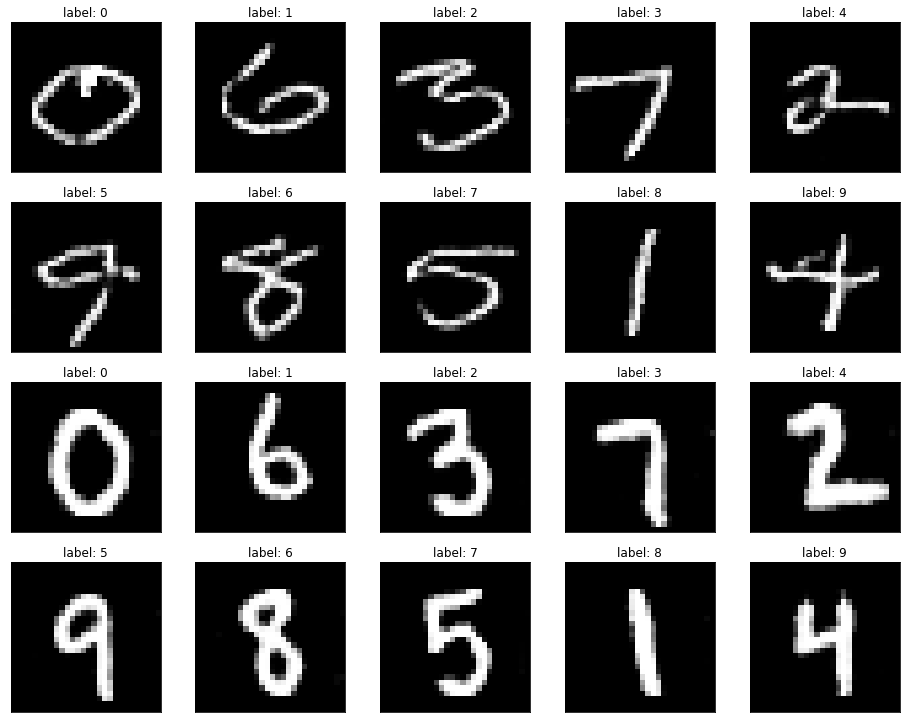


Epoch 00028: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.4902 - d_loss_fake: 0.4971 - g_img_loss: 1.3104 - cat_loss: 0.0075
Epoch 29/40
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.4808 - d_loss_fake: 0.4865 - g_img_loss: 1.3556 - cat_loss: 0.0074

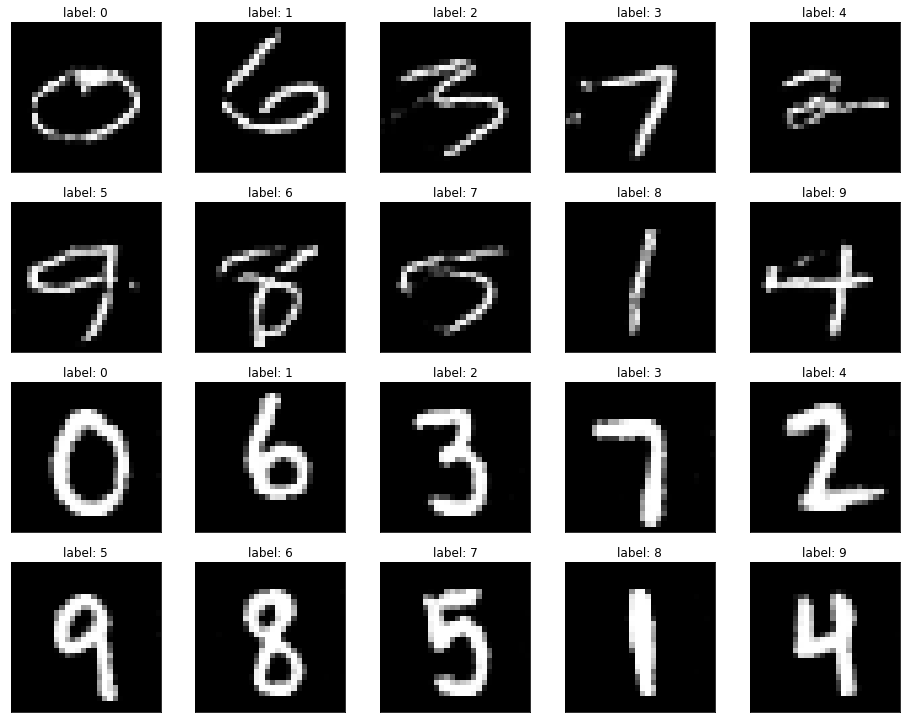


Epoch 00029: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.4808 - d_loss_fake: 0.4865 - g_img_loss: 1.3555 - cat_loss: 0.0074
Epoch 30/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.4737 - d_loss_fake: 0.4806 - g_img_loss: 1.3834 - cat_loss: 0.0077

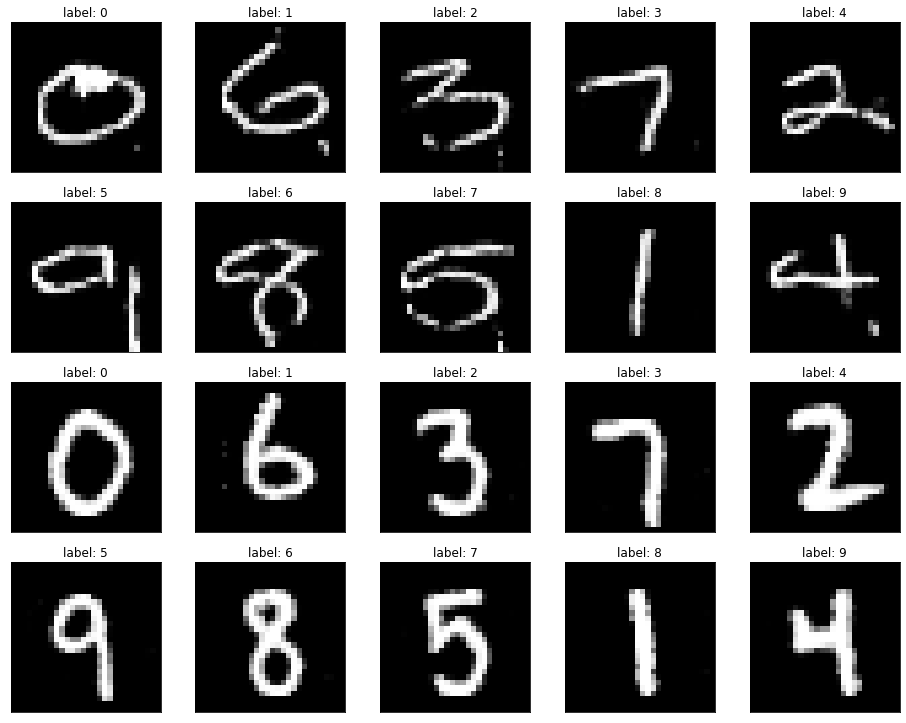


Epoch 00030: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 34s 18ms/step - d_loss_real: 0.4738 - d_loss_fake: 0.4805 - g_img_loss: 1.3835 - cat_loss: 0.0077
Epoch 31/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.4648 - d_loss_fake: 0.4733 - g_img_loss: 1.4232 - cat_loss: 0.0079

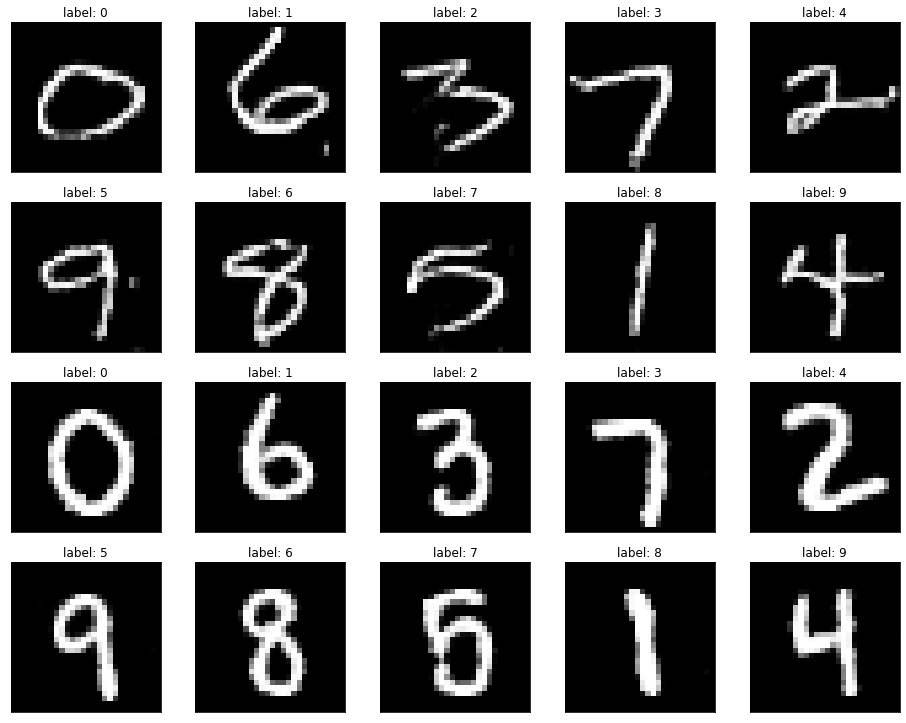


Epoch 00031: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.4648 - d_loss_fake: 0.4733 - g_img_loss: 1.4232 - cat_loss: 0.0079
Epoch 32/40
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.4572 - d_loss_fake: 0.4648 - g_img_loss: 1.4529 - cat_loss: 0.0073

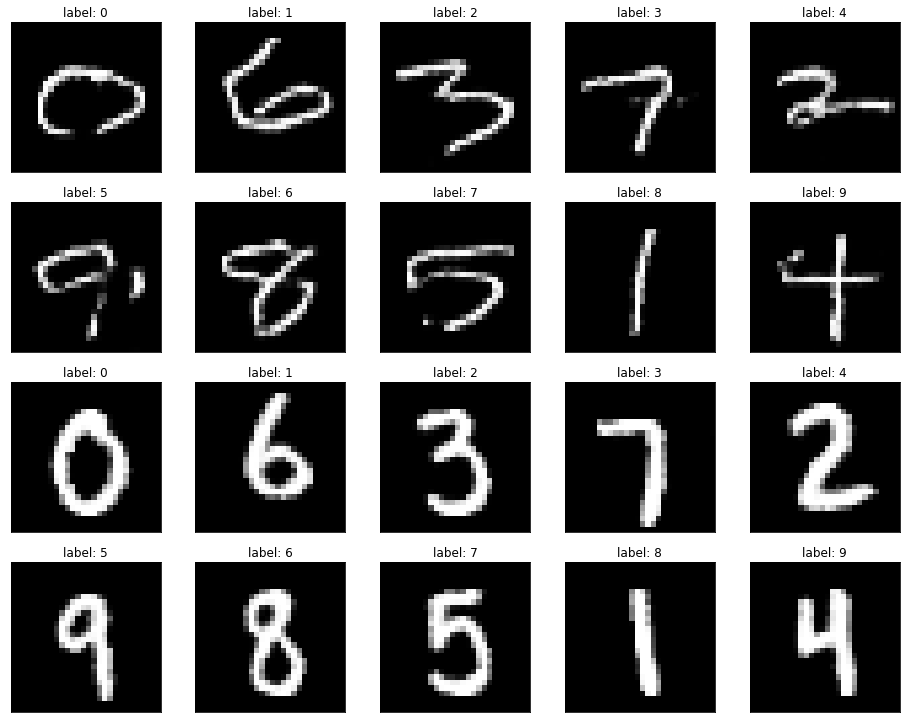


Epoch 00032: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.4573 - d_loss_fake: 0.4647 - g_img_loss: 1.4531 - cat_loss: 0.0073
Epoch 33/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.4467 - d_loss_fake: 0.4559 - g_img_loss: 1.4946 - cat_loss: 0.0074

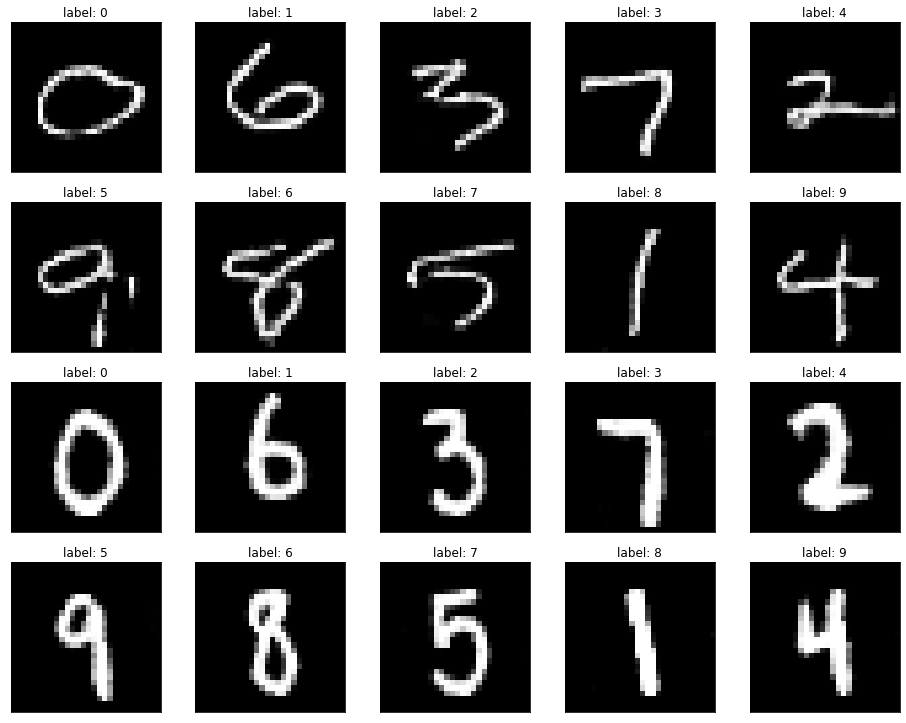


Epoch 00033: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.4467 - d_loss_fake: 0.4559 - g_img_loss: 1.4945 - cat_loss: 0.0074
Epoch 34/40
1872/1875 [============================>.] - ETA: 0s - d_loss_real: 0.4417 - d_loss_fake: 0.4502 - g_img_loss: 1.5253 - cat_loss: 0.0072

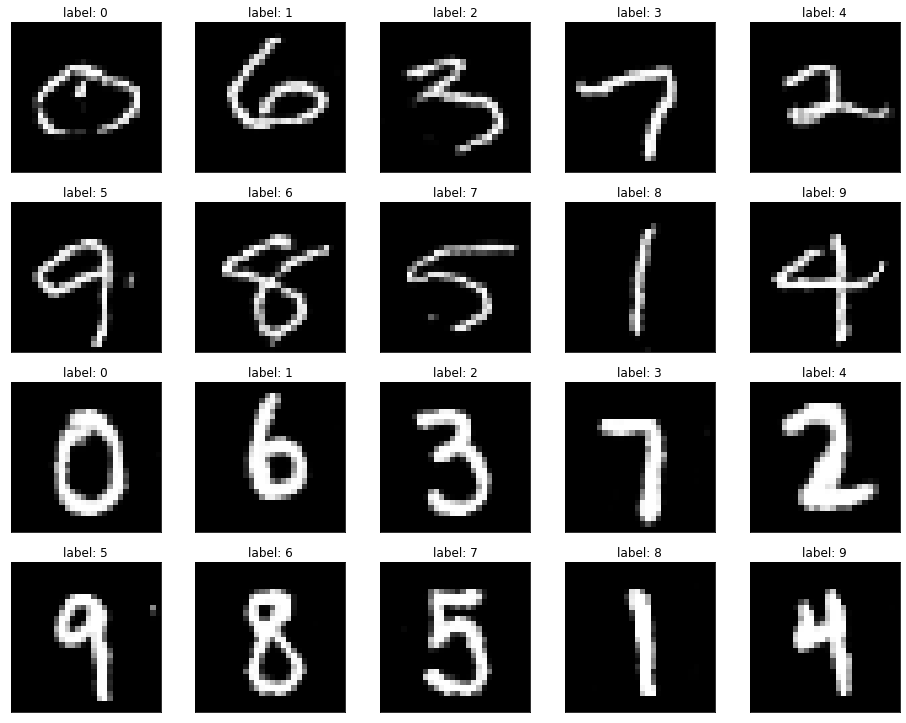


Epoch 00034: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.4416 - d_loss_fake: 0.4502 - g_img_loss: 1.5253 - cat_loss: 0.0072
Epoch 35/40
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.4335 - d_loss_fake: 0.4404 - g_img_loss: 1.5748 - cat_loss: 0.0079

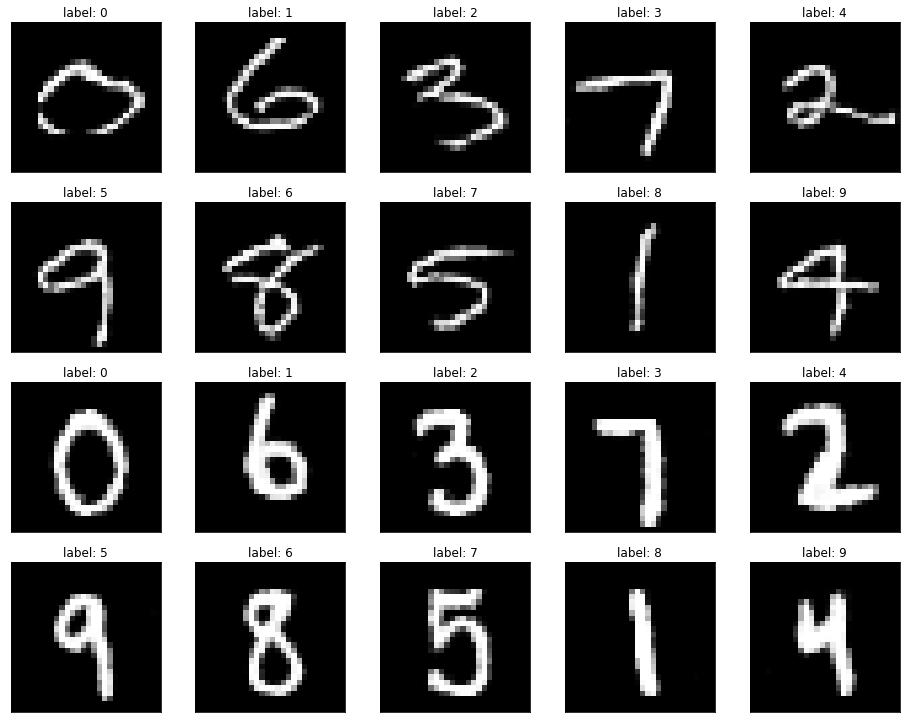


Epoch 00035: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.4335 - d_loss_fake: 0.4404 - g_img_loss: 1.5748 - cat_loss: 0.0079
Epoch 36/40
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.4258 - d_loss_fake: 0.4357 - g_img_loss: 1.5953 - cat_loss: 0.0073

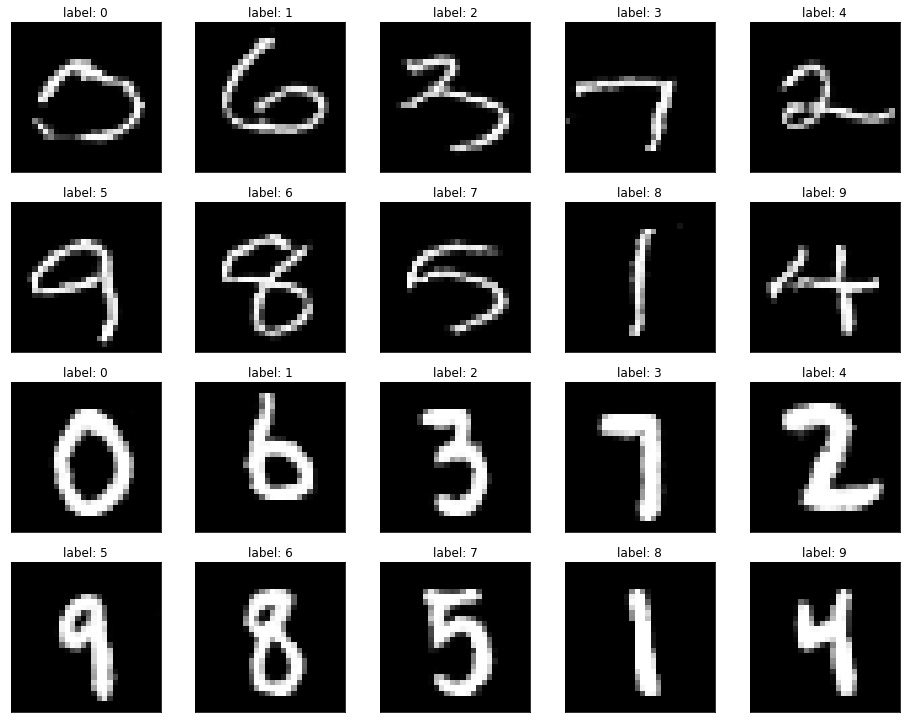


Epoch 00036: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.4257 - d_loss_fake: 0.4357 - g_img_loss: 1.5952 - cat_loss: 0.0073
Epoch 37/40
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.4223 - d_loss_fake: 0.4297 - g_img_loss: 1.6445 - cat_loss: 0.0067

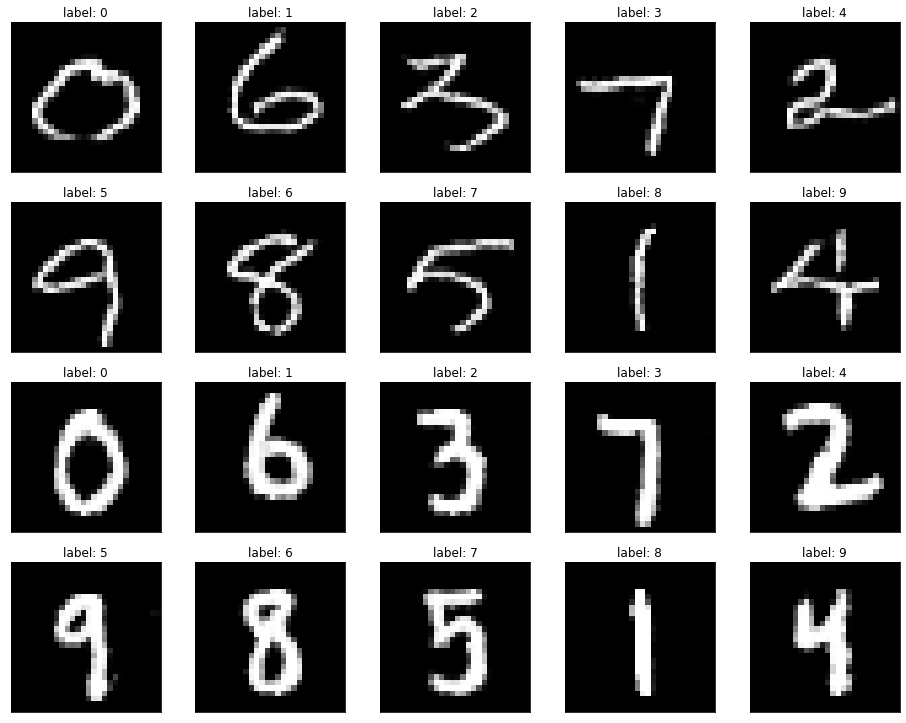


Epoch 00037: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.4224 - d_loss_fake: 0.4298 - g_img_loss: 1.6444 - cat_loss: 0.0067
Epoch 38/40
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.4146 - d_loss_fake: 0.4251 - g_img_loss: 1.6766 - cat_loss: 0.0067

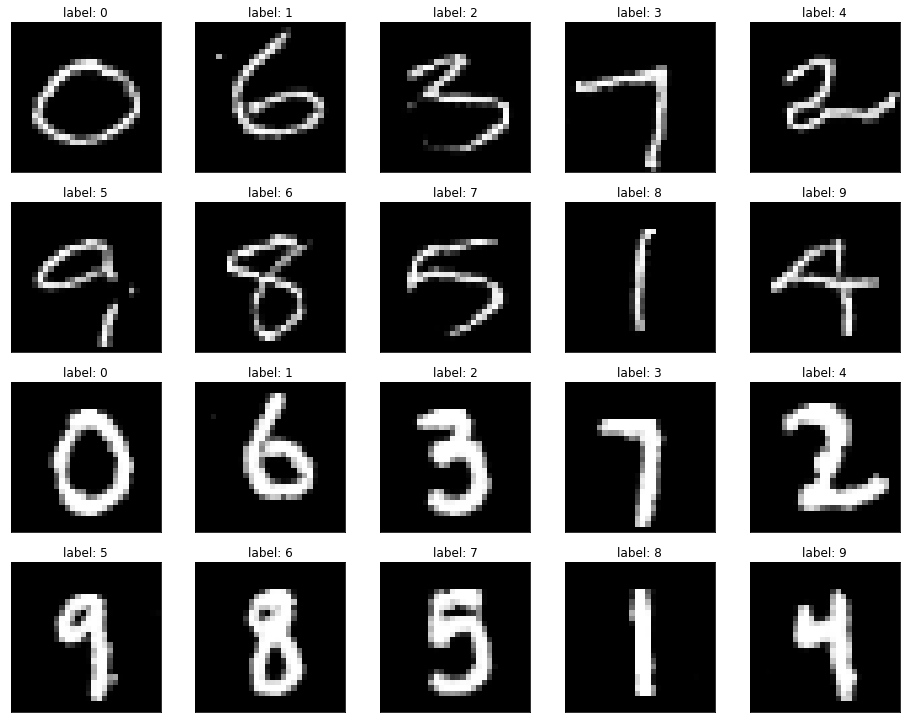


Epoch 00038: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.4146 - d_loss_fake: 0.4253 - g_img_loss: 1.6766 - cat_loss: 0.0067
Epoch 39/40
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.4054 - d_loss_fake: 0.4156 - g_img_loss: 1.7044 - cat_loss: 0.0075

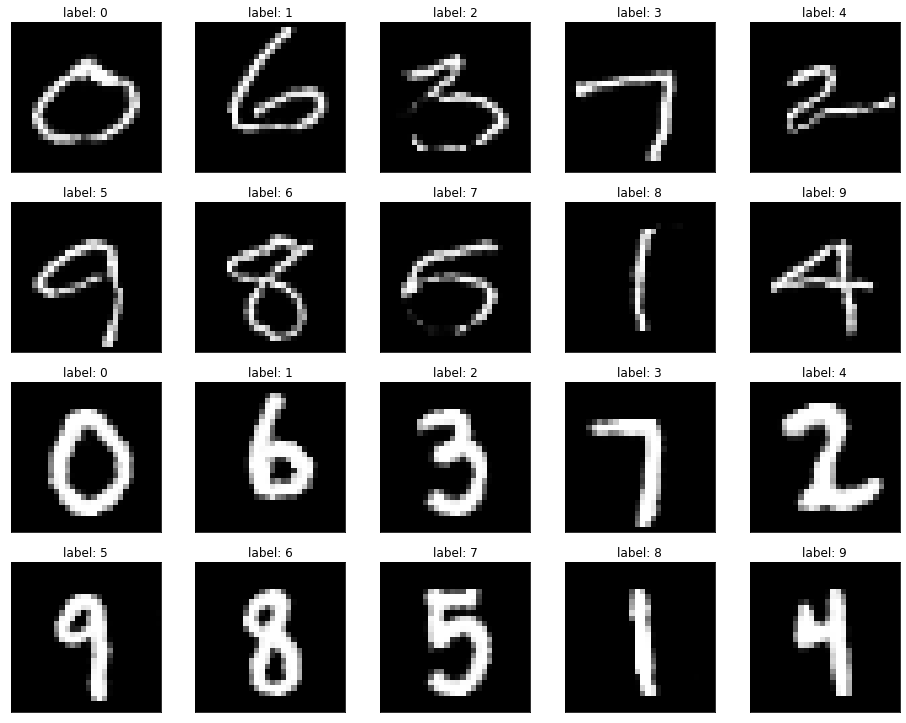


Epoch 00039: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 33s 18ms/step - d_loss_real: 0.4053 - d_loss_fake: 0.4157 - g_img_loss: 1.7044 - cat_loss: 0.0075
Epoch 40/40
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.3997 - d_loss_fake: 0.4108 - g_img_loss: 1.7492 - cat_loss: 0.0074

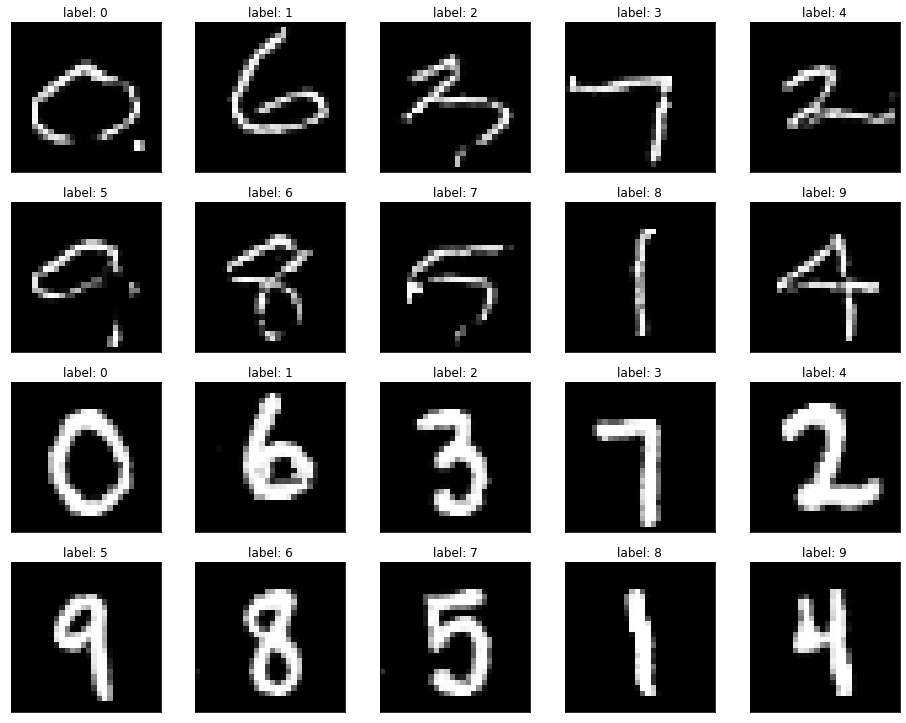


Epoch 00040: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Checkpoints/Checkpoints
1875/1875 [==============================] - 34s 18ms/step - d_loss_real: 0.3997 - d_loss_fake: 0.4108 - g_img_loss: 1.7492 - cat_loss: 0.0074


In [ ]:
real_images = load_real_image(batch_size=32)
infogan.fit(real_images, epochs=40, callbacks=[image_callback, cp_callback])

From the training process, we can notice that the categorical loss drops down very quickly (reached 0.0282 after second epoch). A low categorical loss is a good sign as it means that the model is using the categorical information. The quality of the images start to look good after 22 epochs, **and all the numbers are associated with their corresponding label.** (e.g. label 0 -> number 0, label 1 -> number 6). This means that our model works as expected!

Save the trained models:

In [ ]:
infogan.g_model.save('/content/drive/My Drive/Machine Learning/GAN_MNIST/Models/g_model')
infogan.d_model.save('/content/drive/My Drive/Machine Learning/GAN_MNIST/Models/d_model')
infogan.q_model.save('/content/drive/My Drive/Machine Learning/GAN_MNIST/Models/q_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/GAN_MNIST/Models/g_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/GAN_MNIST/Models/d_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/GAN_MNIST/Models/q_model/assets


### Results

Now let's test the InfoGAN model. As can be seen from the images below, the model successfully utilizes the categorical vector to produce type-specific digits. However, do keep in mind that for the computer, it cannot associated label 0 to number 0. It can only be able to tell there are 10 labels that correspond to 10 different kind of images. 

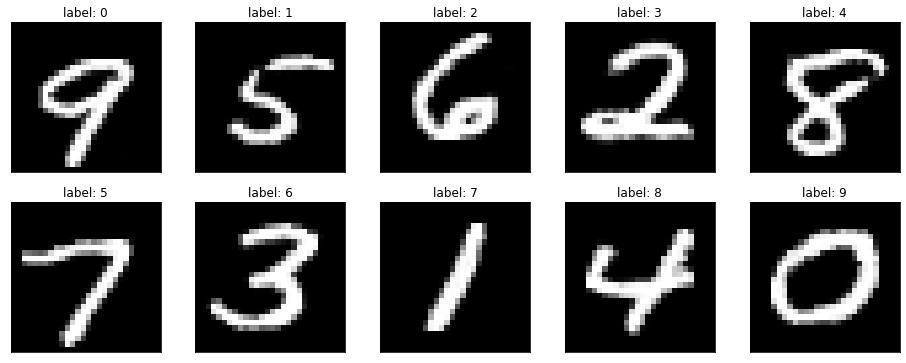

In [ ]:
tf.random.set_seed(None)
noise = tf.random.normal([62])
noise_test = []
for _ in range(10):
    noise_test.append(noise)
noise_test = np.array(noise_test)
label_test = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
label_test = tf.one_hot(label_test, depth=10)
test_input = keras.layers.Concatenate()([label_test, noise_test])
predictions = g_model.predict(test_input)


fig = plt.figure(figsize=(16,16))
for i in range(predictions.shape[0]):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("label: {}".format(np.argmax(label_test[i])))  
plt.show()

We can rearrange the label order to make numbers from 1 to 0 in an order:

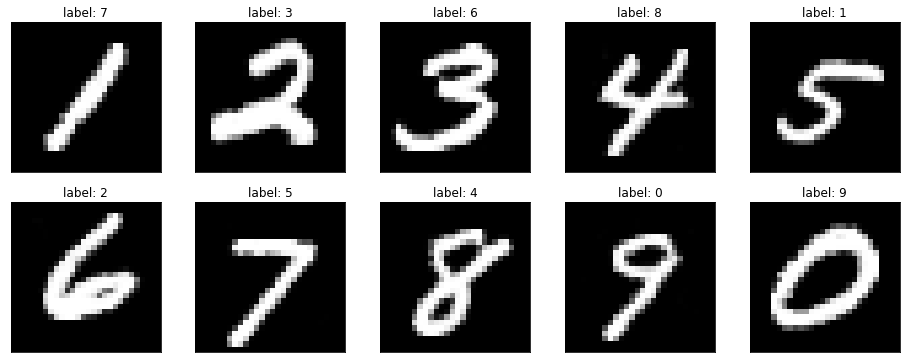

In [ ]:
tf.random.set_seed(None)
noise = tf.random.normal([62])
noise_test = []
for _ in range(10):
    noise_test.append(noise)
noise_test = np.array(noise_test)
label_test = [7, 3, 6, 8, 1, 2, 5, 4, 0, 9]
label_test = tf.one_hot(label_test, depth=10)
test_input = keras.layers.Concatenate()([label_test, noise_test])
predictions = g_model.predict(test_input)
fig = plt.figure(figsize=(16,16))


for i in range(predictions.shape[0]):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("label: {}".format(np.argmax(label_test[i])))  
plt.show()

In [ ]:
tf.random.set_seed(0)
# create noise input
label_test = tf.random.uniform([num_examples_to_generate], minval=0, maxval=10, dtype=tf.int32)
label_test = tf.one_hot(label_test, depth=10)
c_1_test = tf.reshape(tf.constant([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -0.75, -0.5, -0.25, -0.0, 0.25, 0.5, 0.75, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), shape=(25,1))
c_2_test =  tf.reshape(tf.constant([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -0.75, -0.5, -0.25, -0.0, 0.25, 0.5, 0.75, 1.0]), shape= (25,1))
noise_test = tf.random.normal([num_examples_to_generate, noise_dim])
test_input = keras.layers.Concatenate()([label_test, c_1_test, c_2_test, noise_test])

## Categorical and Continuous Latent Codes

Here, I added an additional continuous latent code that contains a float number randomly picked between -1 to 1. This continuous latent code can represent some features that are continuous in the images, such as rotational angle or thickness. However, I will not be able to chosse what continuous feature the model should find before the model is trained, as the model is trained in an unsupervised manner. **But this is also the purpose of using InfoGAN: unlike the categorical labels, it is not practical to label the rotational angle or thickness for each number. Therefore, when there is no label given, we need to ask the computer to figure out features for us.**

The generator thus now contains input with size 73.

In [ ]:
def create_generator_continuous(n_filters=128, input_size=73):
    # Build functional API model
    # input
    input = keras.layers.Input(shape=(input_size, ))

    # Fully-connected layer.
    dense_1 = keras.layers.Dense(units=1024, use_bias=False) (input)
    bn_1 = keras.layers.BatchNormalization()(dense_1)
    act_1 = keras.layers.ReLU()(bn_1)
    # Fully-connected layer. The output should be able to reshape into 7x7
    dense_2 = keras.layers.Dense(units=7*7*128, use_bias=False) (act_1)
    bn_2 = keras.layers.BatchNormalization()(dense_2)
    act_2 = keras.layers.ReLU()(bn_2)
    # Reshape
    reshape = keras.layers.Reshape(target_shape=(7, 7, 128))(act_2)

    nf = n_filters
    # First transposed convolutional layer

    tc_1 = keras.layers.Conv2DTranspose(nf, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)(reshape)
    bn_1 = keras.layers.BatchNormalization()(tc_1)
    act_1 = keras.layers.ReLU()(bn_1)

    # Number of filters halved after each transposed convolutional layer
    nf = nf//2
    # Second transposed convolutional layer
    # strides=(2, 2): shape is doubled after the transposed convolution
    tc_2 = keras.layers.Conv2DTranspose(nf, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)(act_1)
    bn_2 = keras.layers.BatchNormalization()(tc_2)
    act_2 = keras.layers.ReLU()(bn_2)

    # Final transposed convolutional layer: output shape: 28x28x1, tanh activation
    output = keras.layers.Conv2DTranspose(1, kernel_size=(4, 4), strides=(1, 1), 
                                         padding="same", activation="tanh")(act_2)
    model = keras.models.Model(inputs=input, outputs=output)
    return model

The discriminator model is the same as above. The auxiliary model has two more outputs: "mu" and "sigma". These two values are used to set up a Gaussian distribution where "mu" is the mean and "sigma" is the standard deviation:

![image](Images/Gaussian.PNG)

In [ ]:
def create_discriminator_continuous(n_filters=64, n_class=10, input_shape=(28, 28, 1)):
    # Build functional API model
    # Image Input
    image_input = keras.layers.Input(shape=input_shape)

    nf = n_filters
    c_1 = keras.layers.Conv2D(nf, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=True)(image_input)
    bn_1 = keras.layers.BatchNormalization()(c_1)
    act_1 = keras.layers.LeakyReLU(alpha=0.1)(bn_1)

    # Number of filters doubled after each convolutional layer
    nf = nf*2
    # Second convolutional layer
    # Output shape: 7x7
    c_2 = keras.layers.Conv2D(nf, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False)(act_1)
    bn_2 = keras.layers.BatchNormalization()(c_2)
    act_2 = keras.layers.LeakyReLU(alpha=0.1)(bn_2)

    # Flatten the convolutional layers
    flatten = keras.layers.Flatten()(act_2)

    # FC layer
    dense = keras.layers.Dense(1024, use_bias=False)(flatten)
    bn = keras.layers.BatchNormalization()(dense)
    act = keras.layers.LeakyReLU(alpha=0.1)(bn)
    # Discriminator output. Sigmoid activation function to classify "True" or "False"
    d_output = keras.layers.Dense(1, activation='sigmoid')(act)

    # Auxiliary output. 
    q_dense = keras.layers.Dense(128, use_bias=False)(act)
    q_bn = keras.layers.BatchNormalization()(q_dense)
    q_act = keras.layers.LeakyReLU(alpha=0.1)(q_bn)

    # Classification (discrete output)
    clf_out = keras.layers.Dense(n_class, activation="softmax")(q_act)

    # Gaussian distribution mean (continuous output)
    mu = keras.layers.Dense(1)(q_act)

    # Gaussian distribution standard deviation (exponential activation to ensure the value is positive)
    sigma = keras.layers.Dense(1, activation=lambda x: tf.math.exp(x))(q_act)

    # Discriminator model (not compiled)
    d_model = keras.models.Model(inputs=image_input, outputs=d_output)

    # Auxiliary model (not compiled)
    q_model = keras.models.Model(inputs=image_input, outputs=[clf_out, mu, sigma])
    return d_model, q_model

In [ ]:
g_model_continuous = create_generator_continuous()
d_model_continuous, q_model_continuous = create_discriminator_continuous()

The InfoGAN_Continuous model is very much alike to the InfoGAN model we defined before, except that it has an additional loss for auxiliary model. This loss is for the continuous latent code and represented as a negative log probability density function of the Gaussian distribution for the continuous latent code. Through minimizing the loss, mathematically [we are maximizing the likelyhood of having the continuous latent code lying within the Gaussian distribution.](https://engineering.taboola.com/predicting-probability-distributions/)

In [ ]:
class InfoGAN_Continuous(keras.Model):
    def __init__(self, d_model, g_model, q_model,noise_size, num_classes):
        super(InfoGAN_Continuous, self).__init__()
        self.d_model = d_model
        self.g_model = g_model
        self.q_model = q_model
        self.noise_size = noise_size
        self.num_classes = num_classes

    def compile(self, d_optimizer, g_optimizer, q_optimizer):
        super(InfoGAN_Continuous, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.q_optimizer = q_optimizer

    def create_gen_input(self, batch_size, noise_size, n_class, seed=None):
        # create noise input
        noise = tf.random.normal([batch_size, noise_size], seed=seed)
        # Create categorical latent code
        label = tf.random.uniform([batch_size], minval=0, maxval=10, dtype=tf.int32, seed=seed)
        label = tf.one_hot(label, depth=n_class)
        # Create two continuous latent codes
        c_1 = tf.random.uniform([batch_size, 1], minval=-1, maxval=1, seed=seed)
        return label, c_1, noise

    def concat_inputs(self, input):
        concat_input = keras.layers.Concatenate()(input)
        return concat_input

    def train_step(self, real_image_batch):
        # Define loss functions
        binary_loss = keras.losses.BinaryCrossentropy()
        categorical_loss = keras.losses.CategoricalCrossentropy()
        # Half-batch for training discriminator and batch for training GAN
        batch = tf.shape(real_image_batch)[0]
        # batch = batch * 2
        # Create generator input 
        g_label, c_1, g_noise = self.create_gen_input(batch, self.noise_size, self.num_classes, seed=None)
        g_input = self.concat_inputs([g_label, c_1, g_noise])
        with tf.GradientTape() as d_tape: 
            self.d_model.trainable = True
            d_tape.watch(self.d_model.trainable_variables)
            # Train discriminator using half batch real images
            y_disc_real = tf.ones((batch, 1))
            d_real_output = self.d_model(real_image_batch, training=True)
            d_loss_real = binary_loss(y_disc_real, d_real_output)
            # Train discriminator using half batch fake images     
            y_disc_fake = tf.zeros((batch, 1))
            # Create fake image batch
            fake_image_batch = self.g_model(g_input, training=True)
            d_fake_output = self.d_model(fake_image_batch, training=True)
            d_loss_fake = binary_loss(y_disc_fake, d_fake_output)
            d_loss = d_loss_real + d_loss_fake
        # Calculate gradients
        d_gradients = d_tape.gradient(d_loss, self.d_model.trainable_variables)
        # Optimize
        self.d_optimizer.apply_gradients(zip(d_gradients, self.d_model.trainable_variables))
        with tf.GradientTape() as g_tape, tf.GradientTape() as q_tape:
            # Create generator input 
            g_label, c_1, g_noise = self.create_gen_input(batch*2, self.noise_size, self.num_classes, seed=None)
            g_input = self.concat_inputs([g_label, c_1, g_noise])
            g_tape.watch(self.g_model.trainable_variables)
            q_tape.watch(self.q_model.trainable_variables)
            # Create fake image batch
            fake_image_batch = self.g_model(g_input, training=True)
            d_fake_output = self.d_model(fake_image_batch, training=True)
            # Generator Image loss
            y_gen_fake = tf.ones((batch*2, 1))
            g_img_loss = binary_loss(y_gen_fake, d_fake_output)
            # Auxiliary loss
            cat_output, mu, sigma = self.q_model(fake_image_batch, training=True)
            # Categorical loss
            cat_loss = categorical_loss(g_label, cat_output)
            # Use Gaussian distributions to represent the output
            dist = tfp.distributions.Normal(loc=mu, scale=sigma)
            # Losses (negative log probability density function as we want to maximize the probability density function)
            c_1_loss = tf.reduce_mean(-dist.log_prob(c_1))
            # Generator total loss
            eta = 1
            g_loss = g_img_loss + eta * (cat_loss + 0.1*c_1_loss)
            # Auxiliary function loss
            q_loss = eta * (cat_loss + 0.1*c_1_loss)
        # Calculate gradients
        # We do not modify the neurons in discriminator when training generator and auxiliary model
        self.d_model.trainable=False
        g_gradients = g_tape.gradient(g_loss, self.g_model.trainable_variables)
        q_gradients = q_tape.gradient(q_loss, self.q_model.trainable_variables)
        # Optimize
        self.g_optimizer.apply_gradients(zip(g_gradients, self.g_model.trainable_variables))
        self.q_optimizer.apply_gradients(zip(q_gradients, self.q_model.trainable_variables))

        return {"d_loss_real": d_loss_real, "d_loss_fake": d_loss_fake, "g_img_loss": g_img_loss ,
                "cat_loss": cat_loss, "c_1_loss": c_1_loss}

We need to also add extra continuous latent code for our customized callback:

In [ ]:
class GenerateAndSaveImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
    # This callback displays the generated images after every epoch to track the performance of the model
        if (epoch+1) % 1 == 0:
        # Create new images based on random input
        # We will reuse this seed overtime (so it's easier) to visualize the progress of the training
        tf.random.set_seed(0)
        noise = tf.random.normal([62])
        noise_test = []
        for _ in range(20):
            noise_test.append(noise)
            noise_test = np.array(noise_test)
            label_test = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            label_test = tf.one_hot(label_test, depth=10)
            c_1_test = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]).astype('float32').reshape((20, 1))
            test_input = keras.layers.Concatenate()([label_test, c_1_test, noise_test])
            predictions = self.model.g_model.predict(test_input)
            fig = plt.figure(figsize=(16,16))

        for i in range(predictions.shape[0]):
            ax = fig.add_subplot(5, 5, i+1)
            ax.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("label: {}, c_1: {:.1f}".format(np.argmax(label_test[i]), c_1_test[i][0]))  

        # plt.savefig('/content/drive/My Drive/Machine Learning/GAN_MNIST/Images/image_at_epoch_{:03d}.png'.format(epoch+1))
        plt.show()


In [ ]:
checkpoint_dir = "/content/drive/My Drive/Machine Learning/GAN_MNIST/New_Checkpoints/Checkpoints"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 verbose=1)
image_callback = GenerateAndSaveImages()

In [ ]:
infogan = InfoGAN_Continuous(d_model_continuous, g_model_continuous, q_model_continuous, noise_size=62, num_classes=10)
infogan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=2e-4),
                g_optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                q_optimizer=keras.optimizers.Adam(learning_rate=2e-4))

In [ ]:
infogan.load_weights(checkpoint_dir)

Epoch 1/5
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.5319 - d_loss_fake: 0.5328 - g_img_loss: 0.9617 - cat_loss: 0.0041 - c_1_loss: -1.0196

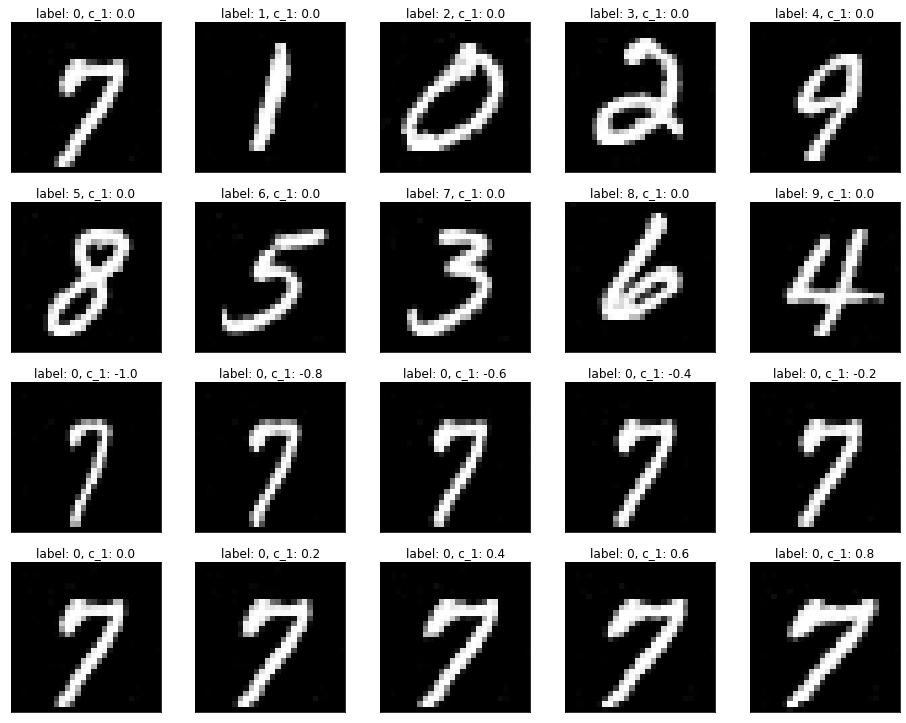


Epoch 00001: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/New_Checkpoints/Checkpoints
1875/1875 [==============================] - 106s 56ms/step - d_loss_real: 0.5319 - d_loss_fake: 0.5329 - g_img_loss: 0.9616 - cat_loss: 0.0041 - c_1_loss: -1.0197
Epoch 2/5
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.5234 - d_loss_fake: 0.5251 - g_img_loss: 0.9781 - cat_loss: 0.0043 - c_1_loss: -1.0191

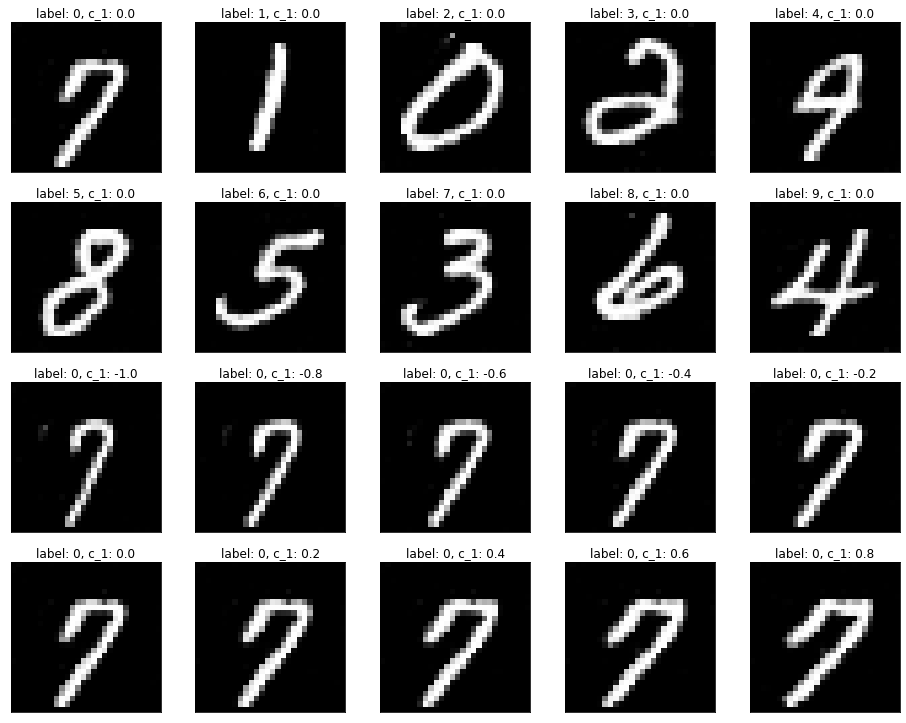


Epoch 00002: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/New_Checkpoints/Checkpoints
1875/1875 [==============================] - 106s 56ms/step - d_loss_real: 0.5233 - d_loss_fake: 0.5251 - g_img_loss: 0.9782 - cat_loss: 0.0043 - c_1_loss: -1.0192
Epoch 3/5
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.5183 - d_loss_fake: 0.5207 - g_img_loss: 0.9895 - cat_loss: 0.0038 - c_1_loss: -1.0347

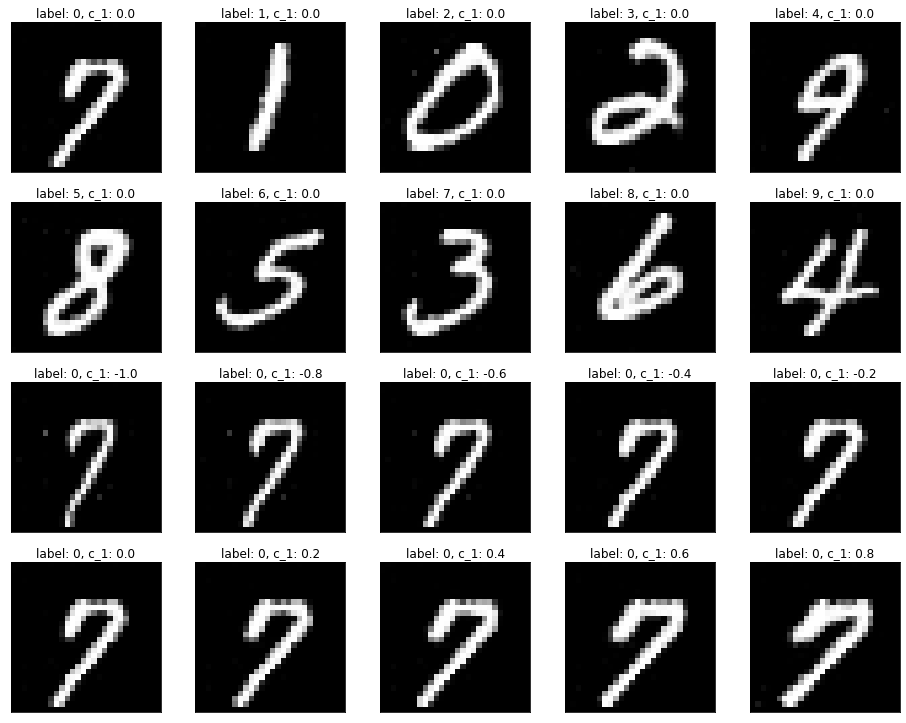


Epoch 00003: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/New_Checkpoints/Checkpoints
1875/1875 [==============================] - 106s 56ms/step - d_loss_real: 0.5184 - d_loss_fake: 0.5207 - g_img_loss: 0.9896 - cat_loss: 0.0038 - c_1_loss: -1.0347
Epoch 4/5
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.5066 - d_loss_fake: 0.5080 - g_img_loss: 0.9876 - cat_loss: 0.0032 - c_1_loss: -1.0548

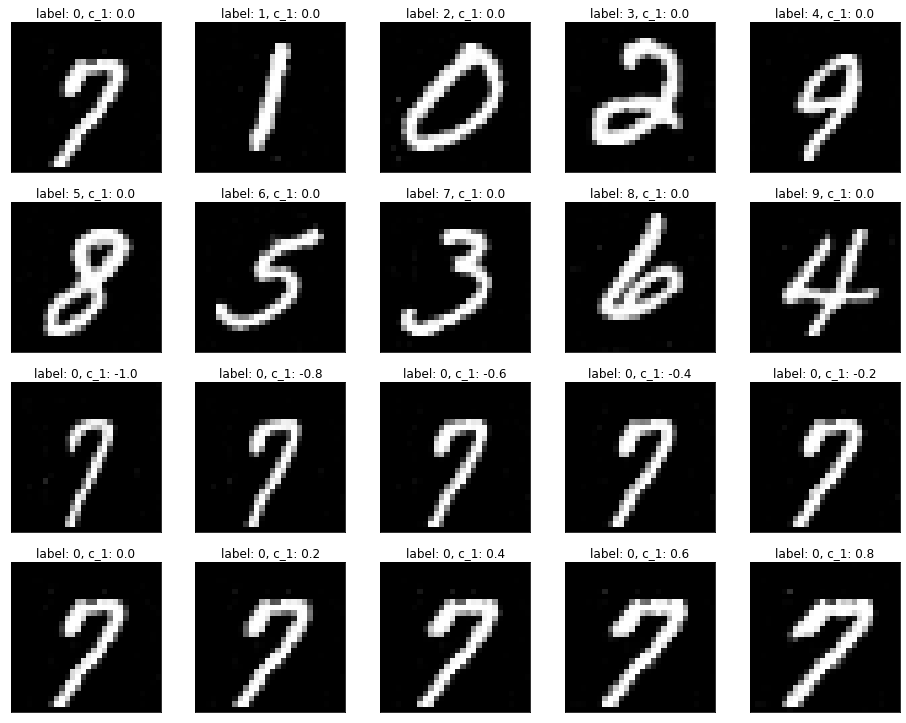


Epoch 00004: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/New_Checkpoints/Checkpoints
1875/1875 [==============================] - 106s 57ms/step - d_loss_real: 0.5066 - d_loss_fake: 0.5080 - g_img_loss: 0.9876 - cat_loss: 0.0032 - c_1_loss: -1.0549
Epoch 5/5
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.4965 - d_loss_fake: 0.4977 - g_img_loss: 0.9867 - cat_loss: 0.0034 - c_1_loss: -1.0652

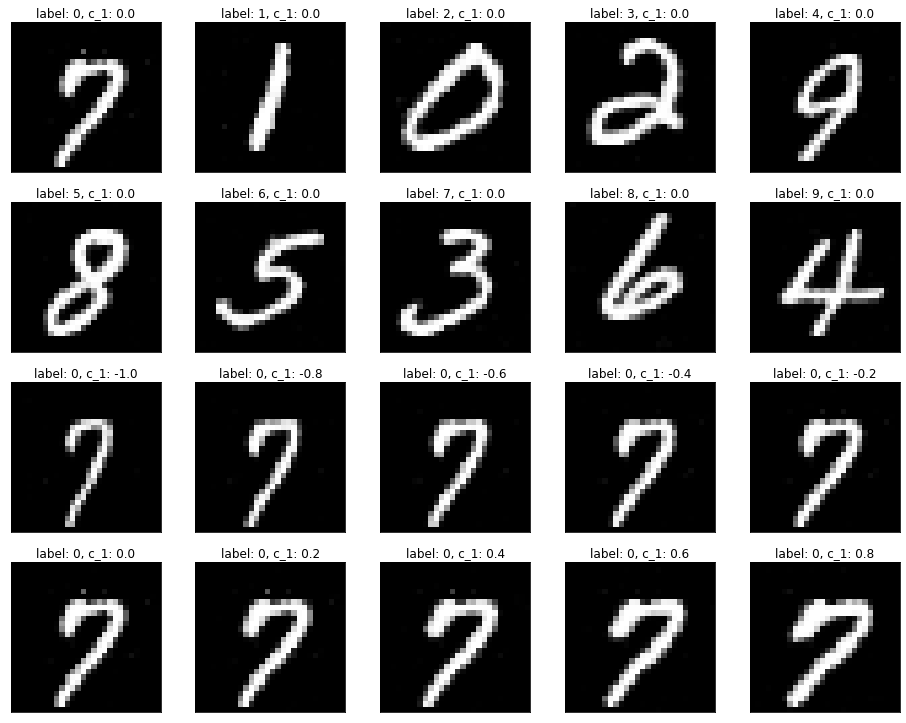


Epoch 00005: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/New_Checkpoints/Checkpoints
1875/1875 [==============================] - 106s 57ms/step - d_loss_real: 0.4965 - d_loss_fake: 0.4977 - g_img_loss: 0.9867 - cat_loss: 0.0034 - c_1_loss: -1.0652


In [ ]:
real_images = load_real_image(batch_size=32)
infogan.fit(real_images, epochs=5, callbacks=[image_callback, cp_callback])

The above training is only part of the training for this model, as the trianing got interrupted and I had to continue training from where it stopped. You can see that when changing the categorical latent code while keeping the continuous latent code constant, different numbers are produced. On the other hand, when changing the continuous latent code while keeping the categorical latent code constant, the number "7" can have different thickness and shape. This means that our model successfully used both the categorical latent code and the continuous latent code.

In [ ]:
infogan.g_model.save('/content/drive/My Drive/Machine Learning/GAN_MNIST/Models/g_model_continuous')
infogan.d_model.save('/content/drive/My Drive/Machine Learning/GAN_MNIST/Models/d_model_continuous')
infogan.q_model.save('/content/drive/My Drive/Machine Learning/GAN_MNIST/Models/q_model_continuous')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/GAN_MNIST/Models/g_model_continuous/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/GAN_MNIST/Models/d_model_continuous/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/GAN_MNIST/Models/q_model_continuous/assets


### Results
Now we've done the training, let's check how our model performs. In the code below I gives model a constant categorical latent code of "6" (corresponds to number "5"), and various of continuous latent codes from -1 to 1. The model can produce number "5" with different shapes. So it works!

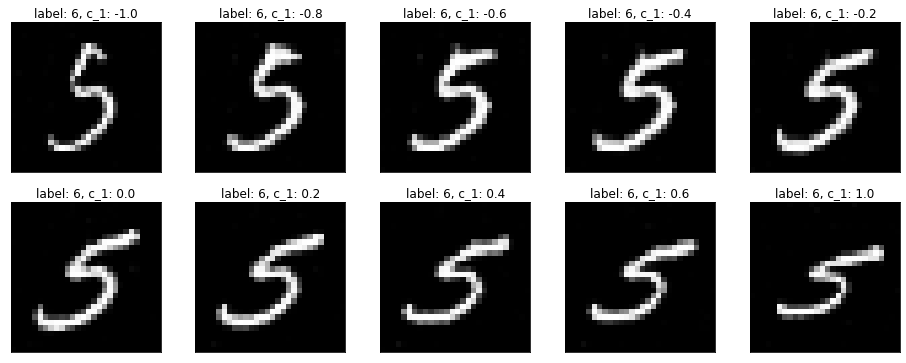

In [ ]:
tf.random.set_seed(0)
noise = tf.random.normal([62])
noise_test = []
for _ in range(10):
    noise_test.append(noise)
noise_test = np.array(noise_test)
label_test = [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
label_test = tf.one_hot(label_test, depth=10)
c_1_test = np.array([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 1]).reshape((10, 1)).astype("float32")
test_input = keras.layers.Concatenate()([label_test, c_1_test, noise_test])
predictions = g_model_continuous.predict(test_input)
fig = plt.figure(figsize=(16,16))

for i in range(predictions.shape[0]):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("label: {}, c_1: {:.1f}".format(np.argmax(label_test[i]), c_1_test[i][0]))  

# plt.savefig('/content/drive/My Drive/Machine Learning/GAN_MNIST/Images/image_at_epoch_{:03d}.png'.format(epoch+1))
plt.show()


# A Fun Experiment - Increase The Loss Ratio for C_1
When I was building the model, I also encountered many problems. One particular problem I encountered was that the model used both the categorical latent code and the continuous latent code for classification. That means, the type of number it produced depend on both the value of categorical latent code and the value of continuous latent code, and if I only changed the categorical latent code, the type of number might not change. I later found out that it was caused by a large ratio for the continuous loss c_1. You may notice that I multiplied the loss for c_1 by 0.1 both when calculating the total generator loss and the total auxiliary model loss. This is because having both the continuous loss c_1 and the categorical loss, it is important to set a small ratio for the continuous function, otherwise the GAN can be confused and mess up the classification. For instance, in the section below I use a ratio for c_1 of 0.5. You will see that changing c_1 will also change the type of the number generated.

In [ ]:
class InfoGAN_Continuous(keras.Model):
    def __init__(self, d_model, g_model, q_model,noise_size, num_classes):
        super(InfoGAN_Continuous, self).__init__()
        self.d_model = d_model
        self.g_model = g_model
        self.q_model = q_model
        self.noise_size = noise_size
        self.num_classes = num_classes

    def compile(self, d_optimizer, g_optimizer, q_optimizer):
        super(InfoGAN_Continuous, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.q_optimizer = q_optimizer

    def create_gen_input(self, batch_size, noise_size, n_class, seed=None):
        # create noise input
        noise = tf.random.normal([batch_size, noise_size], seed=seed)
        # Create categorical latent code
        label = tf.random.uniform([batch_size], minval=0, maxval=10, dtype=tf.int32, seed=seed)
        label = tf.one_hot(label, depth=n_class)
        # Create one continuous latent code
        c_1 = tf.random.uniform([batch_size, 1], minval=-1, maxval=1, seed=seed)
        return label, c_1, noise

    def concat_inputs(self, input):
        concat_input = keras.layers.Concatenate()(input)
        return concat_input

    def train_step(self, real_image_batch):
        # Define loss functions
        binary_loss = keras.losses.BinaryCrossentropy()
        categorical_loss = keras.losses.CategoricalCrossentropy()
        # Half-batch for training discriminator and batch for training GAN
        batch = tf.shape(real_image_batch)[0]
        # Create generator input 
        g_label, c_1, g_noise = self.create_gen_input(batch, self.noise_size, self.num_classes, seed=None)
        g_input = self.concat_inputs([g_label, c_1, g_noise])
        with tf.GradientTape() as d_tape: 
            self.d_model.trainable = True
            d_tape.watch(self.d_model.trainable_variables)
            # Train discriminator using half batch real images
            y_disc_real = tf.ones((batch, 1))
            # Introduce random noise to the labels - a trick to help stabilize training
            d_real_output = self.d_model(real_image_batch, training=True)
            d_loss_real = binary_loss(y_disc_real, d_real_output)
            # Train discriminator using half batch fake images     
            y_disc_fake = tf.zeros((batch, 1))
            # Create fake image batch
            fake_image_batch = self.g_model(g_input, training=True)
            d_fake_output = self.d_model(fake_image_batch, training=True)
            d_loss_fake = binary_loss(y_disc_fake, d_fake_output)
            d_loss = d_loss_real + d_loss_fake
        # Calculate gradients
        d_gradients = d_tape.gradient(d_loss, self.d_model.trainable_variables)
        # Optimize
        self.d_optimizer.apply_gradients(zip(d_gradients, self.d_model.trainable_variables))
        with tf.GradientTape() as g_tape, tf.GradientTape() as q_tape:
            # Create generator input 
            g_label, c_1, g_noise = self.create_gen_input(batch*2, self.noise_size, self.num_classes, seed=None)
            g_input = self.concat_inputs([g_label, c_1, g_noise])
            g_tape.watch(self.g_model.trainable_variables)
            q_tape.watch(self.q_model.trainable_variables)
            # Create fake image batch
            fake_image_batch = self.g_model(g_input, training=True)
            d_fake_output = self.d_model(fake_image_batch, training=True)
            # Generator Image loss
            y_gen_fake = tf.ones((batch*2, 1))
            g_img_loss = binary_loss(y_gen_fake, d_fake_output)
            # Auxiliary loss
            cat_output, mu, sigma = self.q_model(fake_image_batch, training=True)
            # Categorical loss
            cat_loss = categorical_loss(g_label, cat_output)
            # Use Gaussian distributions to represent the output
            dist = tfp.distributions.Normal(loc=mu, scale=sigma)
            # Losses (negative log probability density function as we want to maximize the probability density function)
            c_1_loss = tf.reduce_mean(-dist.log_prob(c_1))
            # Generator total loss
            g_loss = g_img_loss + (cat_loss + 0.5*c_1_loss)
            # Auxiliary function loss
            q_loss = (cat_loss + 0.5*c_1_loss)
        # Calculate gradients
        self.d_model.trainable=False
        g_gradients = g_tape.gradient(g_loss, self.g_model.trainable_variables)
        q_gradients = q_tape.gradient(q_loss, self.q_model.trainable_variables)
        # Optimize
        self.g_optimizer.apply_gradients(zip(g_gradients, self.g_model.trainable_variables))
        self.q_optimizer.apply_gradients(zip(q_gradients, self.q_model.trainable_variables))

        return {"d_loss_real": d_loss_real, "d_loss_fake": d_loss_fake, "g_img_loss": g_img_loss ,
                "cat_loss": cat_loss, "c_1_loss": c_1_loss}

In [ ]:
g_model_continuous_test = create_generator_continuous()
d_model_continuous_test, q_model_continuous_test = create_discriminator_continuous()

In [ ]:
checkpoint_dir = "/content/drive/My Drive/Machine Learning/GAN_MNIST/Test_Checkpoints/Checkpoints"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 verbose=1)
image_callback = GenerateAndSaveImages()

In [ ]:
infogan_test = InfoGAN_Continuous(d_model_continuous_test, g_model_continuous_test, q_model_continuous_test, noise_size=62, num_classes=10)
infogan_test.compile(d_optimizer=keras.optimizers.Adam(learning_rate=2e-4),
                g_optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                q_optimizer=keras.optimizers.Adam(learning_rate=2e-4))

In [ ]:
infogan_test.load_weights(checkpoint_dir)

Epoch 1/10
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.3645 - d_loss_fake: 0.3712 - g_img_loss: 1.6659 - cat_loss: 0.0145 - c_1_loss: -0.9456

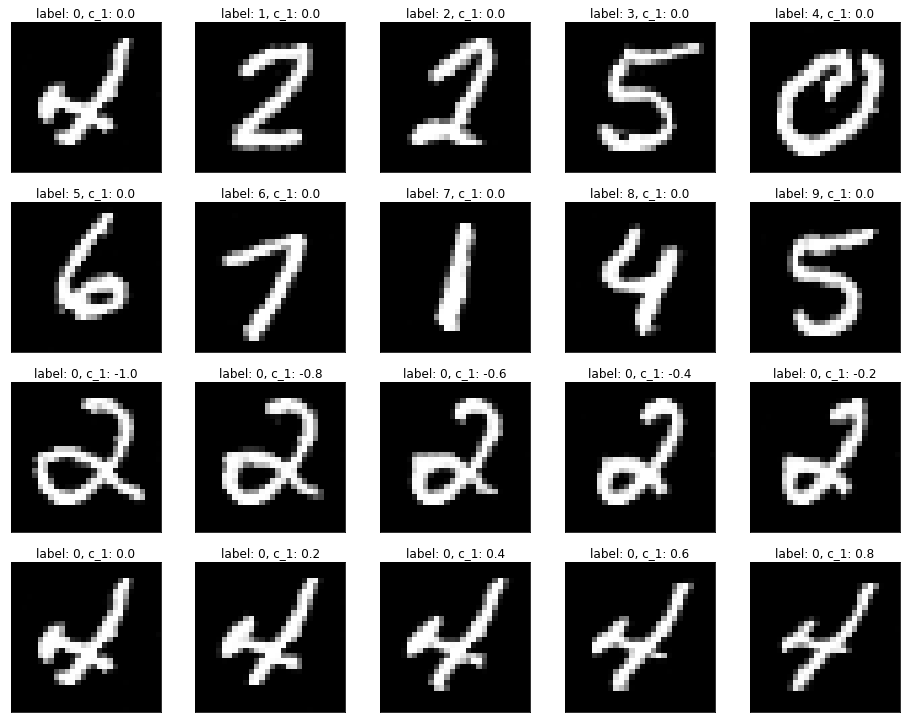


Epoch 00001: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Test_Checkpoints/Checkpoints
1875/1875 [==============================] - 45s 24ms/step - d_loss_real: 0.3644 - d_loss_fake: 0.3712 - g_img_loss: 1.6659 - cat_loss: 0.0145 - c_1_loss: -0.9457
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.3613 - d_loss_fake: 0.3664 - g_img_loss: 1.6787 - cat_loss: 0.0132 - c_1_loss: -0.9569

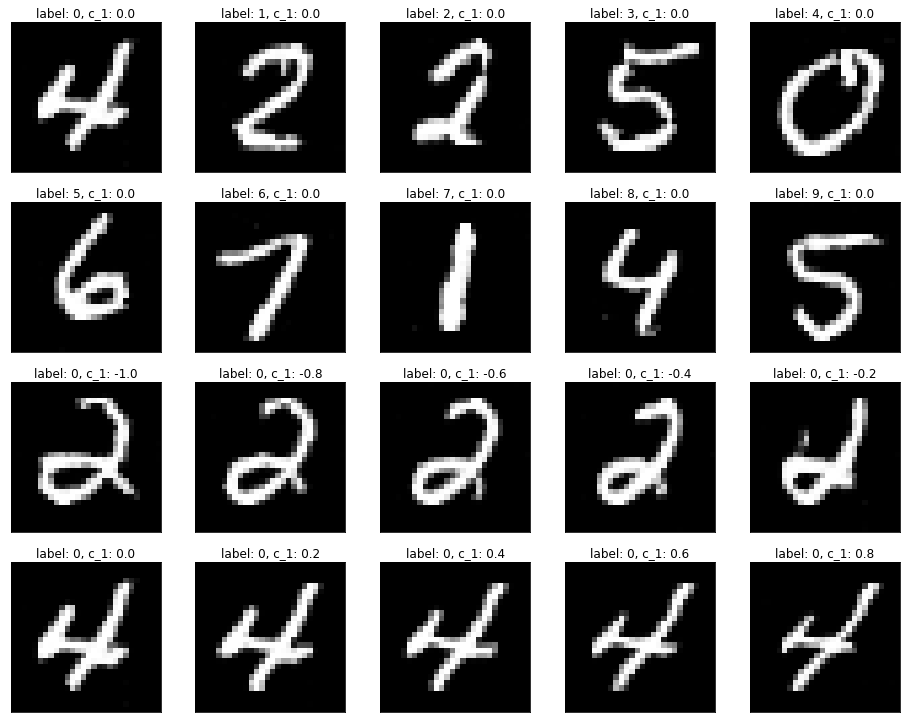


Epoch 00002: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Test_Checkpoints/Checkpoints
1875/1875 [==============================] - 44s 24ms/step - d_loss_real: 0.3612 - d_loss_fake: 0.3665 - g_img_loss: 1.6785 - cat_loss: 0.0132 - c_1_loss: -0.9569
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.3508 - d_loss_fake: 0.3561 - g_img_loss: 1.6906 - cat_loss: 0.0127 - c_1_loss: -0.9627

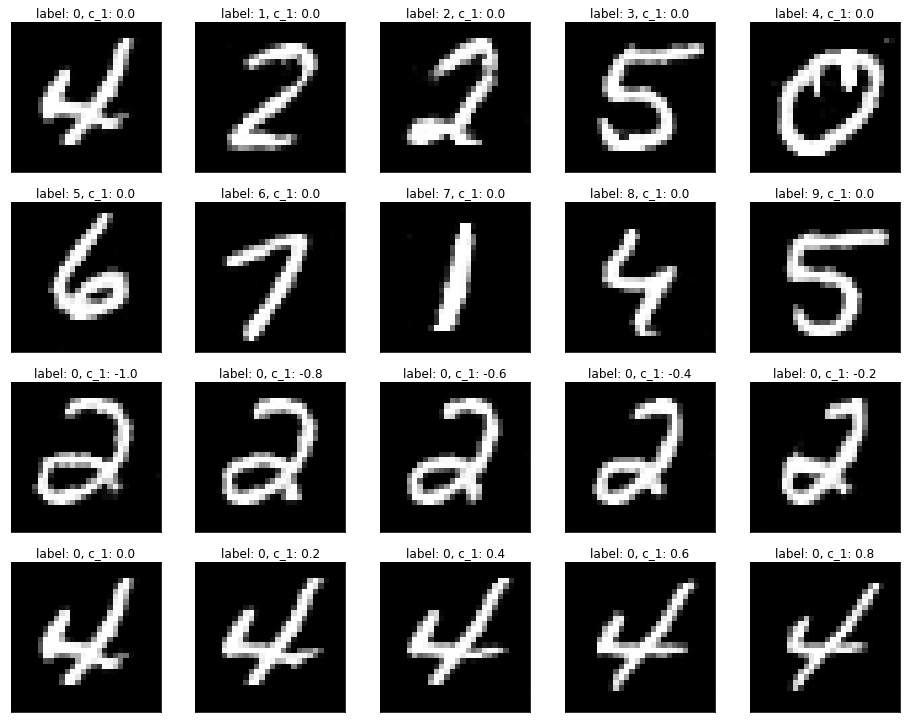


Epoch 00003: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Test_Checkpoints/Checkpoints
1875/1875 [==============================] - 45s 24ms/step - d_loss_real: 0.3510 - d_loss_fake: 0.3560 - g_img_loss: 1.6907 - cat_loss: 0.0127 - c_1_loss: -0.9628
Epoch 4/10
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.3448 - d_loss_fake: 0.3509 - g_img_loss: 1.6967 - cat_loss: 0.0144 - c_1_loss: -0.9682

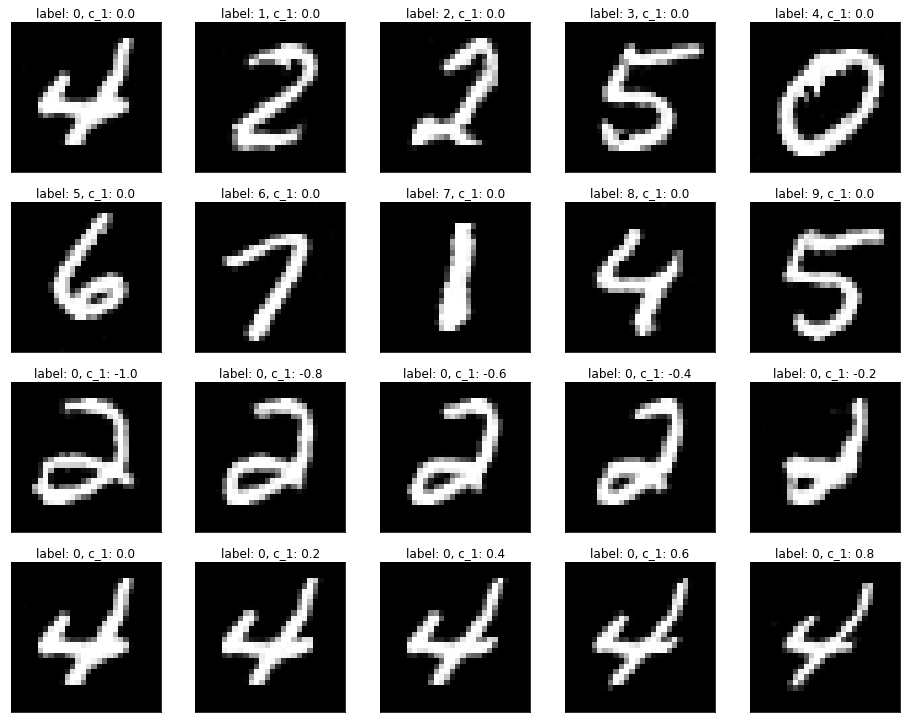


Epoch 00004: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Test_Checkpoints/Checkpoints
1875/1875 [==============================] - 45s 24ms/step - d_loss_real: 0.3446 - d_loss_fake: 0.3514 - g_img_loss: 1.6964 - cat_loss: 0.0144 - c_1_loss: -0.9683
Epoch 5/10
1874/1875 [============================>.] - ETA: 0s - d_loss_real: 0.3350 - d_loss_fake: 0.3402 - g_img_loss: 1.7201 - cat_loss: 0.0134 - c_1_loss: -0.9764

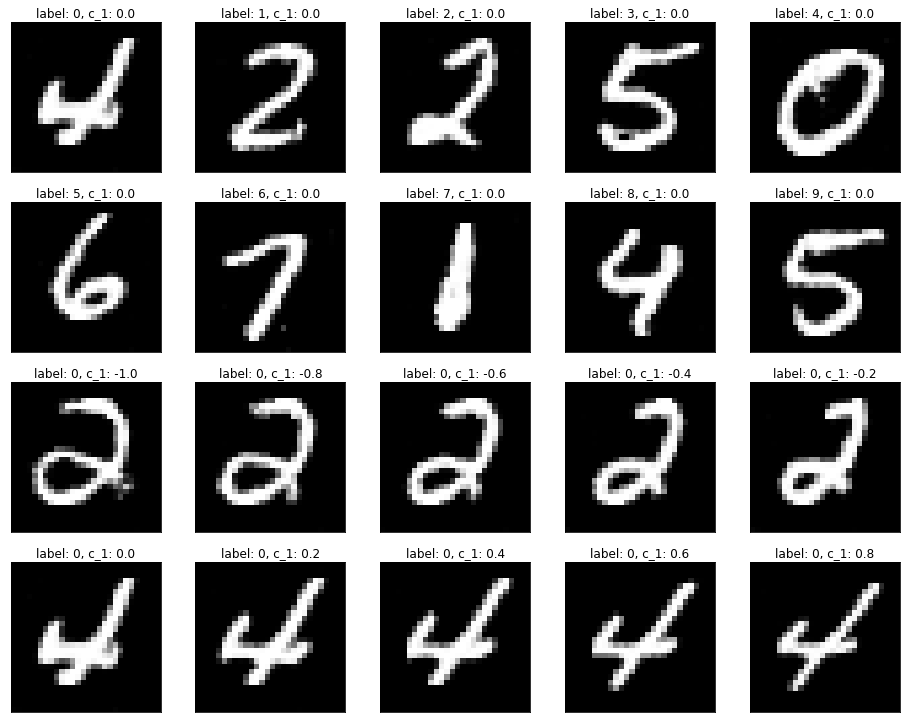


Epoch 00005: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Test_Checkpoints/Checkpoints
1875/1875 [==============================] - 44s 24ms/step - d_loss_real: 0.3350 - d_loss_fake: 0.3403 - g_img_loss: 1.7201 - cat_loss: 0.0135 - c_1_loss: -0.9766
Epoch 6/10
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.3282 - d_loss_fake: 0.3339 - g_img_loss: 1.7449 - cat_loss: 0.0134 - c_1_loss: -0.9959

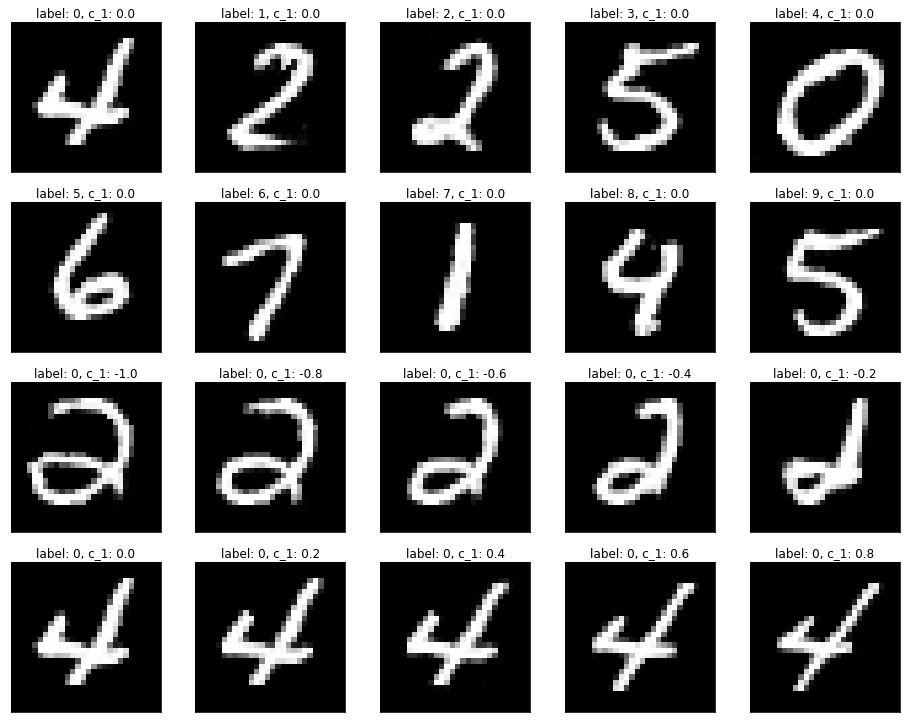


Epoch 00006: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Test_Checkpoints/Checkpoints
1875/1875 [==============================] - 44s 24ms/step - d_loss_real: 0.3283 - d_loss_fake: 0.3339 - g_img_loss: 1.7449 - cat_loss: 0.0134 - c_1_loss: -0.9959
Epoch 7/10
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.3196 - d_loss_fake: 0.3277 - g_img_loss: 1.7643 - cat_loss: 0.0129 - c_1_loss: -0.9973

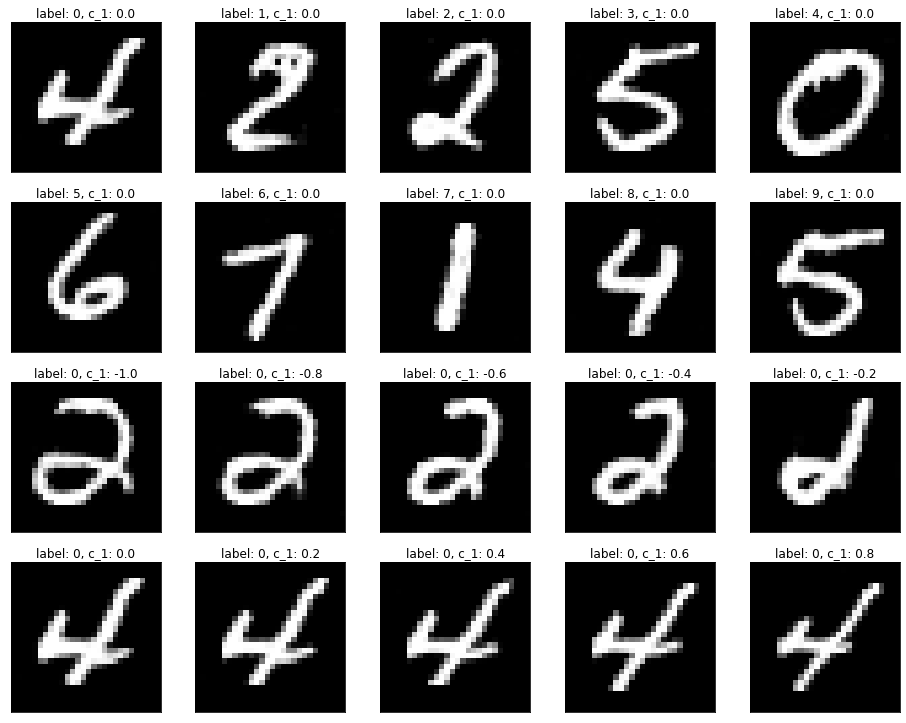


Epoch 00007: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Test_Checkpoints/Checkpoints
1875/1875 [==============================] - 44s 24ms/step - d_loss_real: 0.3195 - d_loss_fake: 0.3278 - g_img_loss: 1.7642 - cat_loss: 0.0129 - c_1_loss: -0.9973
Epoch 8/10
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.3140 - d_loss_fake: 0.3211 - g_img_loss: 1.7605 - cat_loss: 0.0131 - c_1_loss: -1.0014

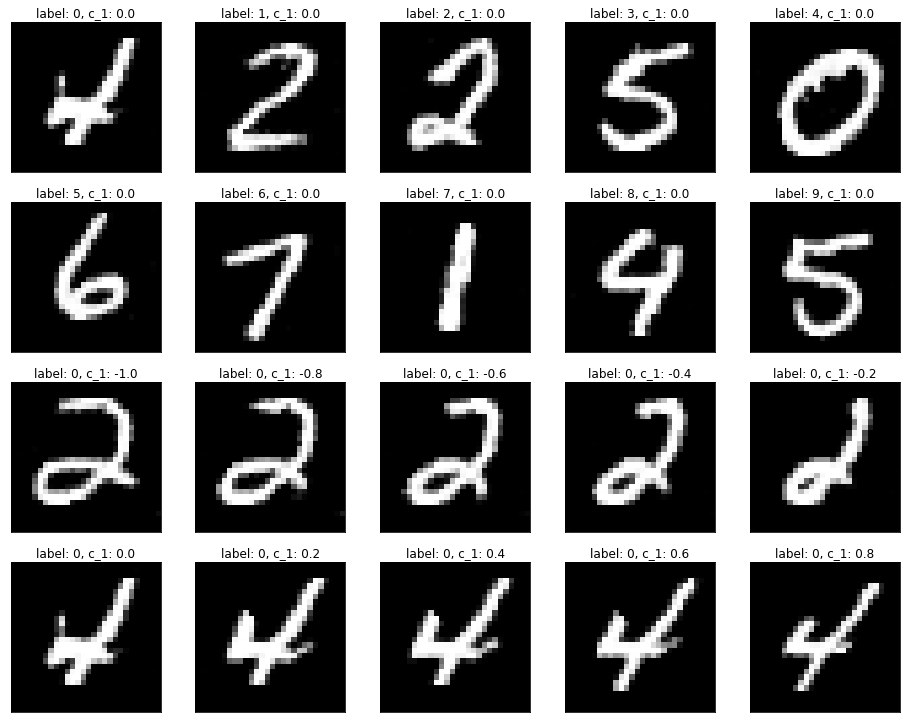


Epoch 00008: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Test_Checkpoints/Checkpoints
1875/1875 [==============================] - 45s 24ms/step - d_loss_real: 0.3138 - d_loss_fake: 0.3211 - g_img_loss: 1.7605 - cat_loss: 0.0131 - c_1_loss: -1.0014
Epoch 9/10
1873/1875 [============================>.] - ETA: 0s - d_loss_real: 0.3055 - d_loss_fake: 0.3113 - g_img_loss: 1.7622 - cat_loss: 0.0130 - c_1_loss: -1.0094

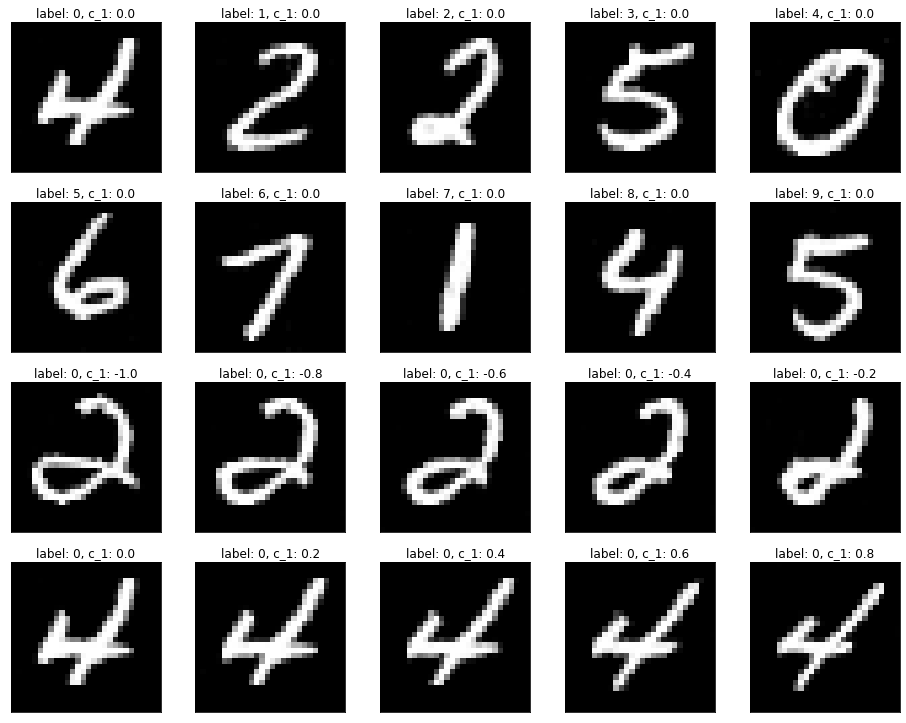


Epoch 00009: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Test_Checkpoints/Checkpoints
1875/1875 [==============================] - 45s 24ms/step - d_loss_real: 0.3055 - d_loss_fake: 0.3116 - g_img_loss: 1.7623 - cat_loss: 0.0130 - c_1_loss: -1.0097
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - d_loss_real: 0.2976 - d_loss_fake: 0.3052 - g_img_loss: 1.7759 - cat_loss: 0.0126 - c_1_loss: -1.0205

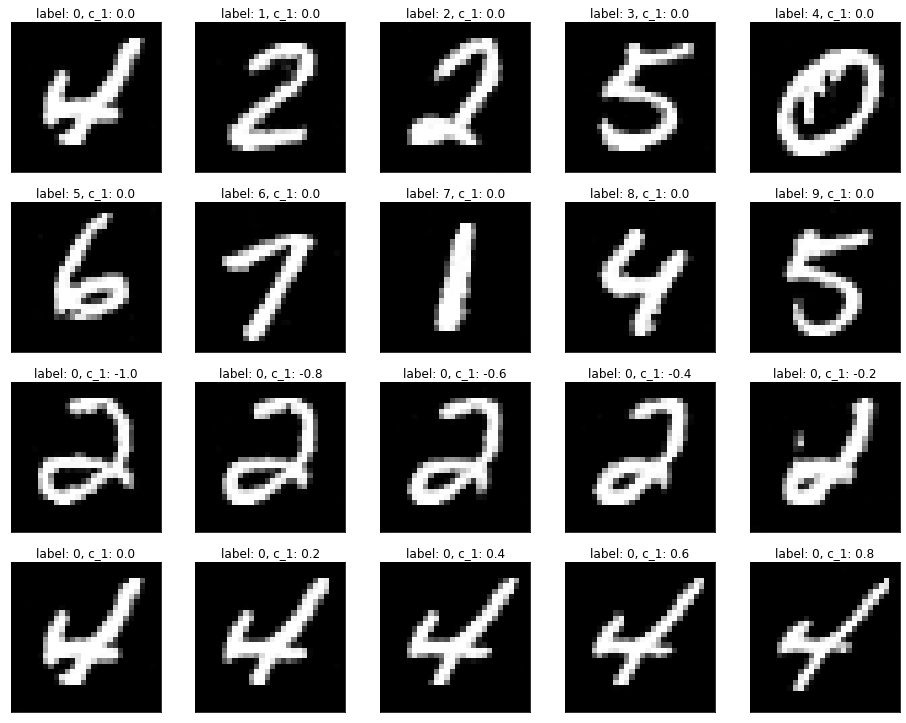


Epoch 00010: saving model to /content/drive/My Drive/Machine Learning/GAN_MNIST/Test_Checkpoints/Checkpoints
1875/1875 [==============================] - 45s 24ms/step - d_loss_real: 0.2975 - d_loss_fake: 0.3054 - g_img_loss: 1.7759 - cat_loss: 0.0126 - c_1_loss: -1.0206


In [ ]:
real_images = load_real_image(batch_size=32)
infogan_test.fit(real_images, epochs=10, callbacks=[image_callback, cp_callback])

## Results

In the code below, I kept the continuous latent code as a constant, and changed only the categorical latent code. However, we can notice that there are two number "2", two number "4", and two number"5", and we are missing number "3", "8", and "9". This is because the continuous latent code also plays a role for classification in this case.

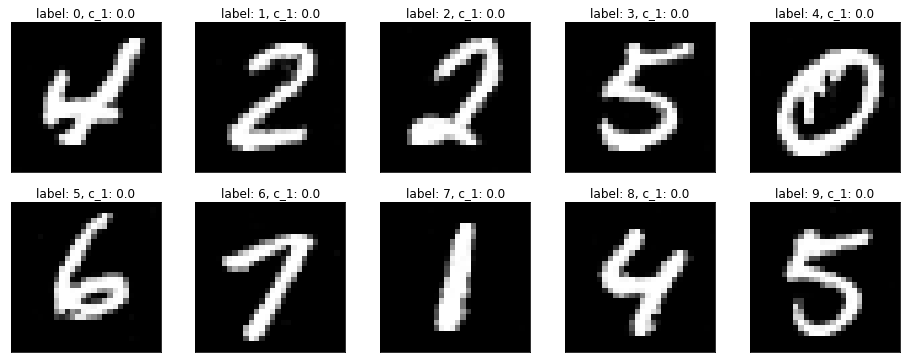

In [ ]:
tf.random.set_seed(0)
noise = tf.random.normal([62])
noise_test = []
for _ in range(10):
    noise_test.append(noise)
noise_test = np.array(noise_test)
label_test = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
label_test = tf.one_hot(label_test, depth=10)
c_1_test = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape((10, 1)).astype('float32')
test_input = keras.layers.Concatenate()([label_test, c_1_test, noise_test])
predictions = g_model_continuous_test.predict(test_input)
fig = plt.figure(figsize=(16,16))

for i in range(predictions.shape[0]):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("label: {}, c_1: {:.1f}".format(np.argmax(label_test[i]), c_1_test[i][0]))  

# plt.savefig('/content/drive/My Drive/Machine Learning/GAN_MNIST/Images/image_at_epoch_{:03d}.png'.format(epoch+1))
plt.show()

As can be seen in the following code, when we only change the continuous latent code, number "2" can actually become number "8", which was missing in the previous image! Also notice that even though c_1 is trained from -1 to 1, when using values outside of the range (1.2, 1.4 in the case below), I can still produce meaningful images.

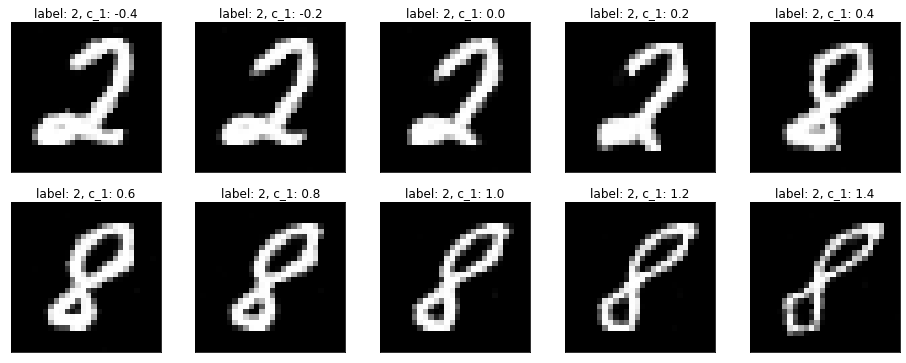

In [ ]:
tf.random.set_seed(0)
noise = tf.random.normal([62])
noise_test = []
for _ in range(10):
    noise_test.append(noise)
noise_test = np.array(noise_test)
label_test = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
label_test = tf.one_hot(label_test, depth=10)
c_1_test = np.array([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]).reshape((10, 1)).astype('float32')
test_input = keras.layers.Concatenate()([label_test, c_1_test, noise_test])
predictions = g_model_continuous_test.predict(test_input)
fig = plt.figure(figsize=(16,16))

for i in range(predictions.shape[0]):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("label: {}, c_1: {:.1f}".format(np.argmax(label_test[i]), c_1_test[i][0]))  

# plt.savefig('/content/drive/My Drive/Machine Learning/GAN_MNIST/Images/image_at_epoch_{:03d}.png'.format(epoch+1))
plt.show()

As can be seen below, the model still correctly predicts all the labels. However, it somehow thinks "2" and "8" in this case are the same thing. This is because c_1 disturbs the classification.

In [ ]:
np.argmax(q_model_continuous_test(predictions)[0], axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
infogan_test.g_model.save('/content/drive/My Drive/Machine Learning/GAN_MNIST/Models/g_model_continuous_large_C1')
infogan_test.d_model.save('/content/drive/My Drive/Machine Learning/GAN_MNIST/Models/d_model_continuous_large_C1')
infogan_test.q_model.save('/content/drive/My Drive/Machine Learning/GAN_MNIST/Models/q_model_continuous_large_C1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/GAN_MNIST/Models/g_model_continuous_large_C1/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/GAN_MNIST/Models/d_model_continuous_large_C1/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Machine Learning/GAN_MNIST/Models/q_model_continuous_large_C1/assets
